In [1]:
import os, gc, datetime, time
import pandas as pd, numpy as np
from tqdm import tqdm_notebook
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [16, 8] # setting figure size

sns.set()
sns.set_style('whitegrid')
sns.set_color_codes()

In [3]:
import pickle

import os, sys, gc 
from plotnine import *
import plotnine

import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
from matplotlib import rc
import re
from matplotlib.ticker import PercentFormatter
from sklearn import model_selection, preprocessing, metrics
from sklearn.metrics import roc_auc_score

### 데이터 로드 

In [4]:
train_trans = pd.read_csv("./train_transaction.csv")
train_idf = pd.read_csv("./train_identity.csv")

test_trans = pd.read_csv("./test_transaction.csv")
test_idf = pd.read_csv("./test_identity.csv")

In [5]:
test_idf.columns = [c.replace('-', '_') if '-' in c else c for c in test_idf.columns]

In [6]:
train_trans['TransactionDay'] = train_trans['TransactionDT'] // (24*60*60)
test_trans['TransactionDay'] = test_trans['TransactionDT'] // (24*60*60)

In [7]:
"""
train_trans[
    (train_trans['card1'] == 18383) & 
    (train_trans['card2'] == 128) & 
    (train_trans['card3'] == 150) & 
    (train_trans['card4'] == 'visa') & 
    (train_trans['card5'] == 226) & 
    (train_trans['card6'] == 'credit')
]
"""

train_trans.loc[[232040, 336013, 425671, 511094]][['TransactionID', 'TransactionDT', 'D1', 'D3']]

TransactionID  TransactionDT     D1    D3
232040        3219040        5504516  449.0  24.0
336013        3323013        8275288  481.0  32.0
425671        3412671       10772608  510.0  29.0
511094        3498094       13378525  540.0  30.0

In [8]:
for i in range(1, 16): 
    # i가 9이면 hour를 의미해서 패스 
    if i != 9: 
        train_trans['D{}n'.format(i)] = train_trans['TransactionDay'] - train_trans['D{}'.format(i)]
        test_trans['D{}n'.format(i)] = test_trans['TransactionDay'] - test_trans['D{}'.format(i)]

In [9]:
train_trans[(train_trans['card1'] == 15775) & (train_trans['D1n'] == -81)][['TransactionID', 'isFraud', 'TransactionAmt', 'card1', 'addr1', 'D1n','TransactionDay' ,'D3n', 'dist1', 'P_emaildomain']]

TransactionID  isFraud  TransactionAmt  card1  addr1   D1n  \
1694         2988694        1           240.0  15775  251.0 -81.0   
10046        2997046        1           260.0  15775  251.0 -81.0   
34029        3021029        1           250.0  15775  251.0 -81.0   
36812        3023812        1           315.0  15775  251.0 -81.0   
40459        3027459        1           390.0  15775  251.0 -81.0   
43926        3030926        1           475.0  15775  251.0 -81.0   
43941        3030941        1           445.0  15775  251.0 -81.0   
44717        3031717        1           445.0  15775  251.0 -81.0   
44727        3031727        1           445.0  15775  251.0 -81.0   
58485        3045485        1           295.0  15775  251.0 -81.0   

       TransactionDay   D3n  dist1 P_emaildomain  
1694                1   0.0    NaN     yahoo.com  
10046               3   1.0    NaN     yahoo.com  
34029               9   3.0    NaN     yahoo.com  
36812              10   9.0    NaN     yahoo.com  
40459              11  10.0    NaN     yahoo.com  
43926              12  11.0    NaN     yahoo.com  
43941              12  12.0    NaN     yahoo.com  
44717              12  12.0    NaN     yahoo.com  
44727              12  12.0   12.0           NaN  
58485              15  12.0    NaN     yahoo.com

In [10]:
agg = train_trans.groupby(['card1', 'addr1', 'D1n'])['isFraud'].agg({'mean','count'}).reset_index()

In [11]:
agg[agg['mean'] == 1].sort_values(by=['count', 'mean'], ascending=[False, False]).head()

card1  addr1    D1n  mean  count
185362  17188  122.0 -139.0   1.0     84
146715  13623  498.0  117.0   1.0     80
92234    9002  272.0  -92.0   1.0     78
24959    2939  204.0 -137.0   1.0     76
101019   9749  226.0   -5.0   1.0     60

In [12]:
agg[(agg['mean'] > 0) & (agg['mean'] != 1)].sort_values(by=['count', 'mean'], ascending=[False, False]).head()

card1  addr1    D1n      mean  count
137764  12695  325.0 -342.0  0.731707    123
98960    9500  330.0   17.0  0.903614     83
139449  12839  264.0   40.0  0.016949     59
183595  16998  330.0  -37.0  0.051724     58
139445  12839  264.0   36.0  0.017241     58

In [13]:
train_trans['is_this_transaction_in_test_data'] = 'train'
test_trans['is_this_transaction_in_test_data'] = 'test'
total_trans = pd.concat([train_trans, test_trans], axis=0, sort=False)

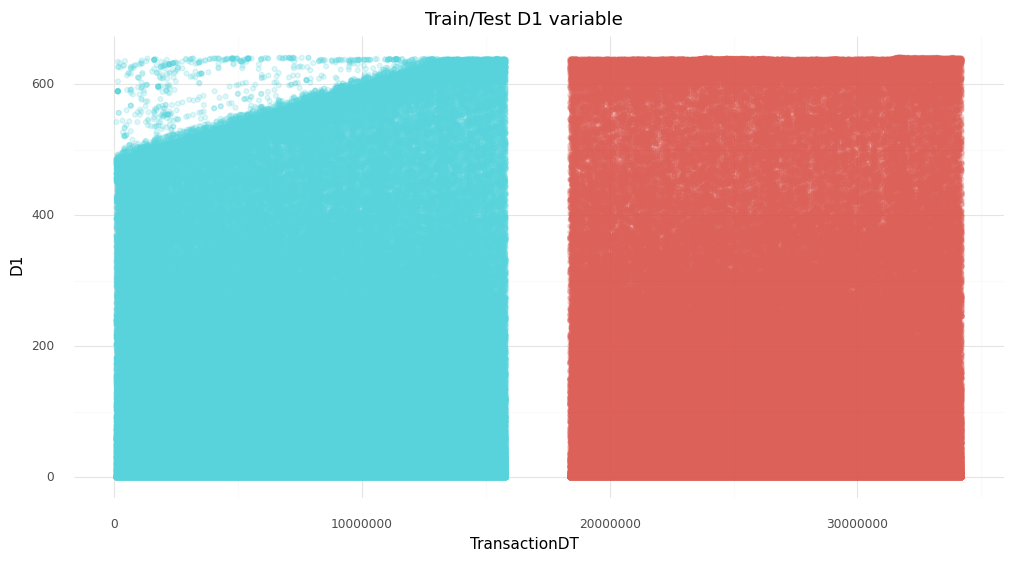

<ggplot: (152087379905)>

In [14]:
(ggplot(data = total_trans) 
     + geom_point(aes(x='TransactionDT', y ='D1', group='is_this_transaction_in_test_data', colour='is_this_transaction_in_test_data'), alpha = 0.2)
     + theme_minimal()
     + ggtitle("Train/Test D1 variable") 
     + labs(x = "TransactionDT") 
     + theme(legend_position = "none", figure_size=(12,6))
) 


In [15]:
# Data Merge
train_df = pd.merge(train_trans,train_idf,how='left',on='TransactionID')
test_df = pd.merge(test_trans,test_idf,how='left',on='TransactionID')

In [16]:
from sklearn.preprocessing import LabelEncoder

for col in tqdm_notebook(train_df.columns):
    if train_df[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train_df[col].astype(str).values) + list(test_df[col].astype(str).values))
        train_df[col] = le.transform(list(train_df[col].astype(str).values))
        test_df[col] = le.transform(list(test_df[col].astype(str).values))

In [17]:
id_feature = [ c for c in train_df.columns if c.find('id_') !=-1]
v_feature = [ c for c in train_df.columns if c.find('V') !=-1]
card_feature = [ c for c in train_df.columns if c.find('card') !=-1]
C_feature = [ c for c in train_df.columns if c.find('C') !=-1 and c != 'ProductCD']
D_feature = [ c for c in train_df.columns if c.find('n') == -1 and c.find('D') !=-1 and c not in ['ProductCD','TransactionID','TransactionDT','DeviceType','DeviceInfo','TransactionDay']]
Dn_feature = [ c for c in train_df.columns if c.find('n') != -1 and c.find('D') !=-1 and c not in ['ProductCD','TransactionID','TransactionDT','DeviceType','DeviceInfo','TransactionDay']]
M_feature = [ c for c in train_df.columns if c.find('M') !=-1]

In [18]:
total_df = pd.concat([train_df, test_df], axis=0, sort=False)
target = total_df['is_this_transaction_in_test_data'].values
train, test = model_selection.train_test_split(total_df, test_size=0.33, random_state=42, shuffle=True)

train_y = train['is_this_transaction_in_test_data'].values
test_y = test['is_this_transaction_in_test_data'].values

# TransactionDT ~ M columns 
features = np.append(['TransactionDT', 'TransactionAmt', 'ProductCD'], card_feature + Dn_feature + C_feature + M_feature)
train_ = lgb.Dataset(train[features], label=train_y)
test_ = lgb.Dataset(test[features], label=test_y)

In [19]:
# 문제점
# 파라미터에 따라서 아래와 결과가 달라짐. 
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }

In [20]:
num_round = 50
clf = lgb.train(params, train_, num_round, valid_sets = [train_, test_], verbose_eval=50, early_stopping_rounds = 50)

Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.999999	valid_1's auc: 0.999998
Did not meet early stopping. Best iteration is:
[22]	training's auc: 1	valid_1's auc: 0.999999


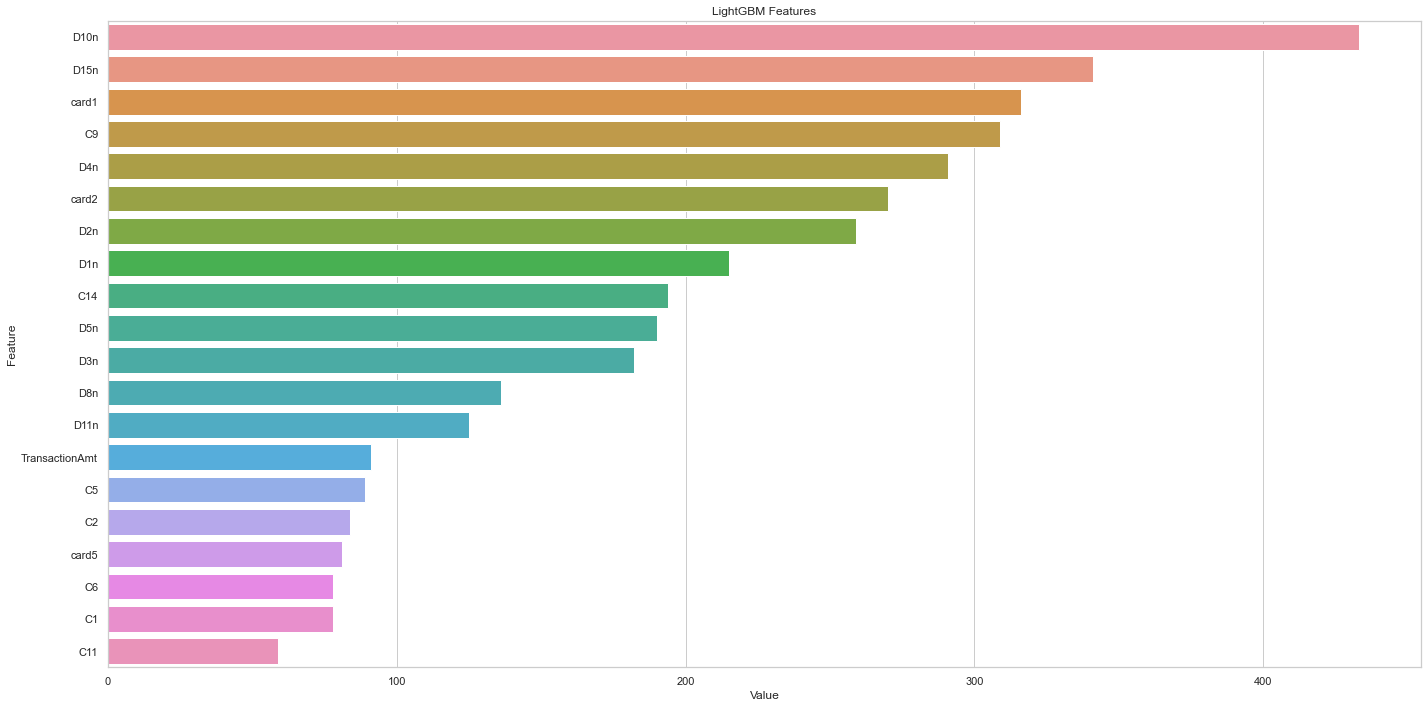

<Figure size 1152x576 with 0 Axes>

In [21]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(),features)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

In [22]:
# TransactionDT ~ M columns 
features = v_feature
train_ = lgb.Dataset(train[features], label=train_y)
test_ = lgb.Dataset(test[features], label=test_y)

num_round = 50
clf = lgb.train(params, train_, num_round, valid_sets = [train_, test_], verbose_eval=50, early_stopping_rounds = 50)

Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.760991	valid_1's auc: 0.752336
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.760991	valid_1's auc: 0.752336


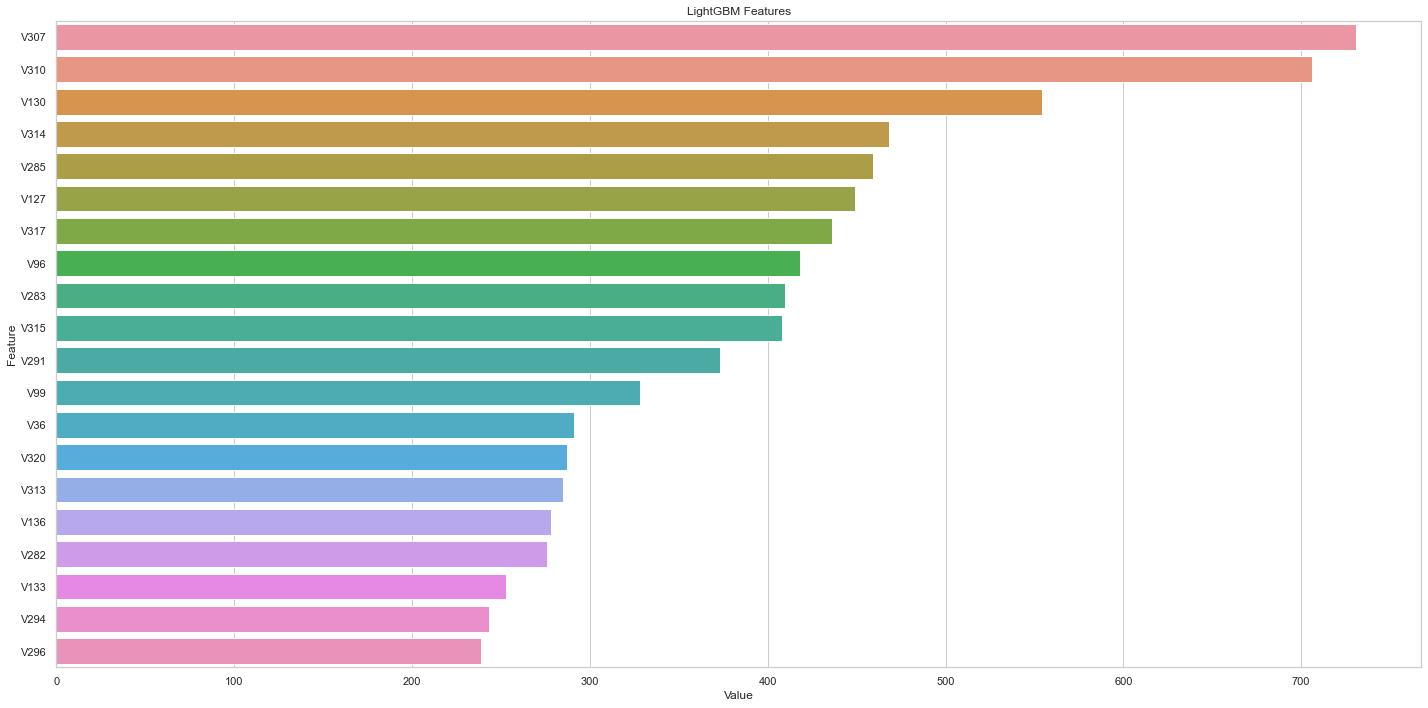

<Figure size 1152x576 with 0 Axes>

In [23]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(),features)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-02.png')

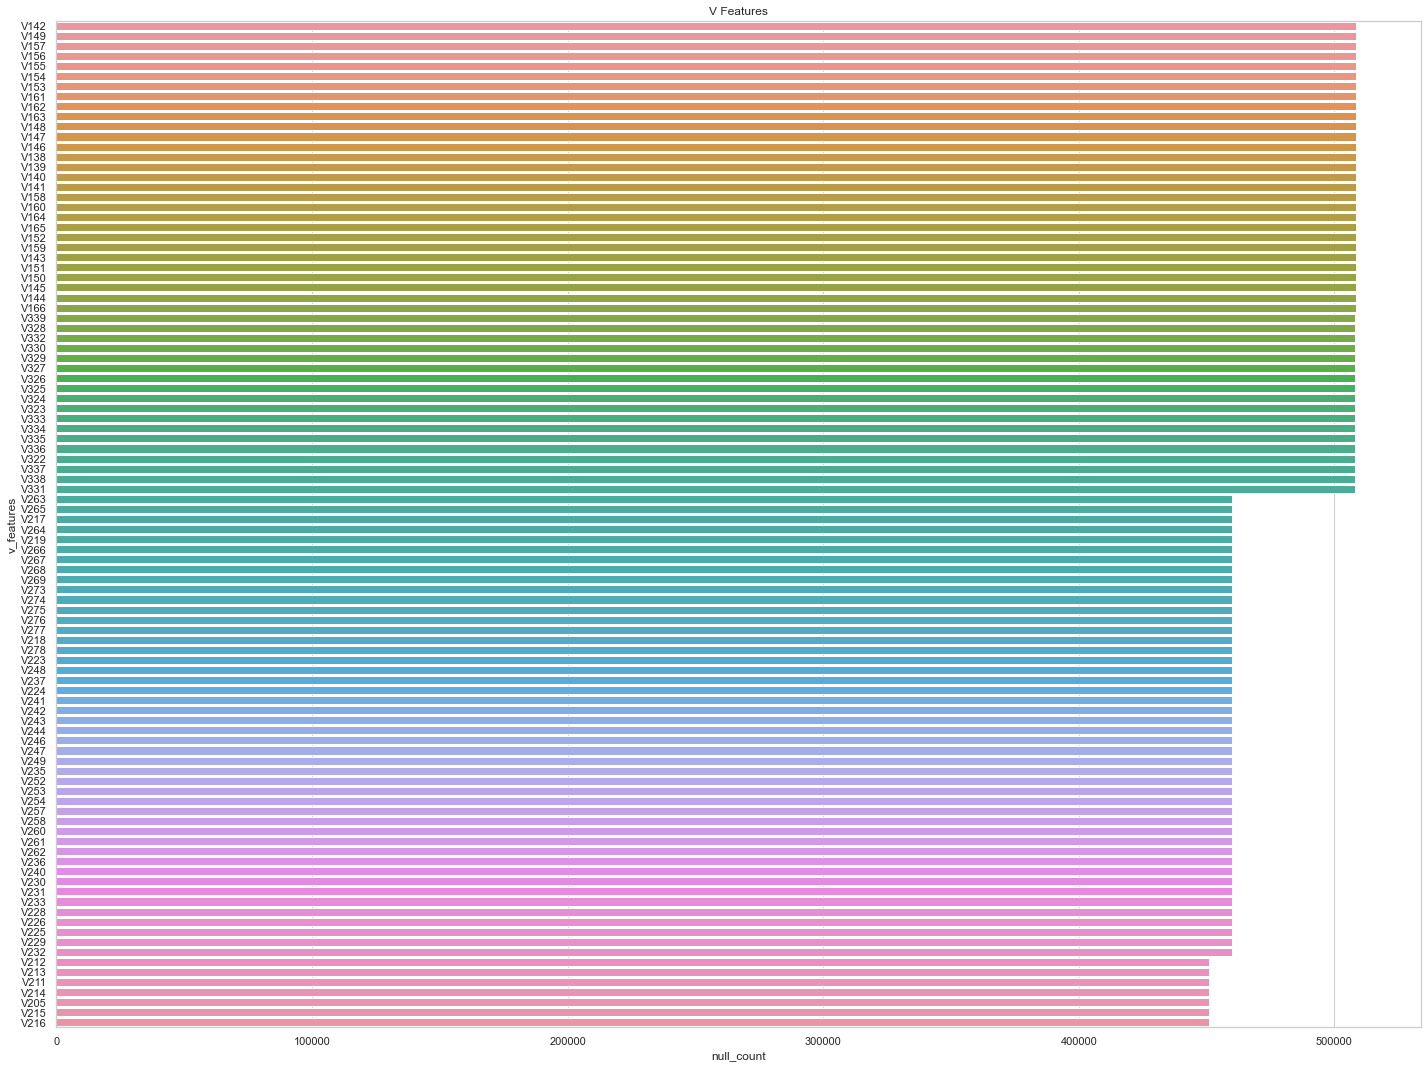

<Figure size 1152x576 with 0 Axes>

In [24]:
nullsum = pd.DataFrame(train_df[v_feature].isnull().sum()).reset_index()
nullsum.columns = ['v_features', 'null_count']

plt.figure(figsize=(20, 15))
sns.barplot(x="null_count", y="v_features", data=nullsum.sort_values(by="null_count", ascending=False).head(100))
plt.title('V Features')
plt.tight_layout()
plt.show()
plt.savefig('Null Count-03.png')

## Feature Engineering 

In [25]:
# Data Merge
X_train = pd.merge(train_trans,train_idf,how='left',on='TransactionID')
X_test = pd.merge(test_trans,test_idf,how='left',on='TransactionID')

In [26]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')

# LABEL ENCODE
def encode_LE(col,train=X_train,test=X_test,verbose=True):
    df_comb = pd.concat([train[col],test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True)
    nm = col
    if df_comb.max()>32000: 
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print(nm,', ',end='')

# GROUP AGGREGATION MEAN AND STD
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=X_train, test_df=X_test, 
              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')

                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)

                print("'"+new_col_name+"'",', ',end='')

# COMBINE FEATURES
def encode_CB(col1,col2,df1=X_train,df2=X_test):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    encode_LE(nm,verbose=False)
    print(nm,', ',end='')

# GROUP AGGREGATION NUNIQUE
def encode_AG2(main_columns, uids, train_df=X_train, test_df=X_test):
    for main_column in main_columns:  
        for col in uids:
            comb = pd.concat([train_df[[col]+[main_column]],test_df[[col]+[main_column]]],axis=0)
            mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
            print(col+'_'+main_column+'_ct, ',end='')

In [27]:
encode_FE(X_train,X_test,['addr1','card1','card2','card3','P_emaildomain'])
encode_CB('card1','addr1')
encode_CB('card1_addr1','P_emaildomain')
encode_FE(X_train,X_test,['card1_addr1','card1_addr1_P_emaildomain'])

addr1_FE , card1_FE , card2_FE , card3_FE , P_emaildomain_FE , card1_addr1 , card1_addr1_P_emaildomain , card1_addr1_FE , card1_addr1_P_emaildomain_FE , 

## Feature Selection
- time consistency
- correlation analysis

### Time consistency

In [28]:
# ADD MONTH FEATURE
import datetime
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
train_df['DT_M'] = train_df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
train_df['DT_M'] = (train_df['DT_M'].dt.year-2017)*12 + train_df['DT_M'].dt.month 

# SPLIT DATA INTO FIRST MONTH AND LAST MONTH
train = train_df[train_df.DT_M==12].copy()
valid = train_df[train_df.DT_M==17].copy()

# train_df AND VALIDATE
lgbm = lgb.LGBMClassifier(n_estimators=500, objective='binary', 
            num_leaves=8, learning_rate=0.02)

In [29]:
score_df = pd.DataFrame()
col_list = []
auc_train_list = []
auc_val_list = []
for col in train.columns.tolist(): 
    # print(col)
    h = lgbm.fit(train[[col]], train.isFraud, eval_metric='auc', 
            eval_set=[(train[[col]],train.isFraud),(valid[[col]],valid.isFraud)], verbose=-1)
    auc_train = np.round(h._best_score['valid_0']['auc'],4)
    auc_valid = np.round(h._best_score['valid_1']['auc'],4)
    
    col_list.append(col)
    auc_train_list.append(auc_train)
    auc_val_list.append(auc_valid)

In [30]:
score_df['colums'] = col_list
score_df['auc_train'] = auc_train_list
score_df['auc_valid'] = auc_val_list
score_df['auc_diff'] = np.abs(score_df['auc_train'] - score_df['auc_valid'])
score_df.sort_values(by='auc_diff', ascending=False)

colums  auc_train  auc_valid  auc_diff
447                             id_38     0.6081     0.3562    0.2519
397                               D3n     0.6006     0.4401    0.1605
64                                V10     0.5576     0.7117    0.1541
65                                V11     0.5577     0.7116    0.1539
396                               D2n     0.6613     0.5215    0.1398
2                       TransactionDT     0.6350     0.5000    0.1350
0                       TransactionID     0.6346     0.5000    0.1346
229                              V175     0.5675     0.6969    0.1294
277                              V223     0.5517     0.6810    0.1293
294                              V240     0.5488     0.6780    0.1292
60                                 V6     0.5495     0.6780    0.1285
295                              V241     0.5487     0.6771    0.1284
281                              V227     0.5603     0.6886    0.1283
280                              V226     0.5503     0.6772    0.1269
55                                 V1     0.5494     0.6756    0.1262
62                                 V8     0.5496     0.6755    0.1259
421                             id_12     0.5697     0.6953    0.1256
56                                 V2     0.5513     0.6769    0.1256
279                              V225     0.5551     0.6802    0.1251
46                                 M1     0.5513     0.6754    0.1241
323                              V269     0.5537     0.6774    0.1237
227                              V173     0.5625     0.6861    0.1236
278                              V224     0.5571     0.6807    0.1236
274                              V220     0.5590     0.6813    0.1223
235                              V181     0.5706     0.6927    0.1221
288                              V234     0.5792     0.7009    0.1217
226                              V172     0.5666     0.6881    0.1215
237                              V183     0.5747     0.6960    0.1213
61                                 V7     0.5568     0.6777    0.1209
293                              V239     0.5689     0.6898    0.1209
290                              V236     0.5655     0.6851    0.1196
314                              V260     0.5619     0.6813    0.1194
248                              V194     0.5728     0.6915    0.1187
291                              V237     0.5631     0.6817    0.1186
238                              V184     0.5741     0.6927    0.1186
289                              V235     0.5593     0.6776    0.1183
330                              V276     0.5610     0.6792    0.1182
249                              V195     0.5743     0.6923    0.1180
292                              V238     0.5670     0.6849    0.1179
234                              V180     0.5773     0.6951    0.1178
302                              V248     0.5678     0.6855    0.1177
331                              V277     0.5667     0.6844    0.1177
214                              V160     0.5941     0.4764    0.1177
303                              V249     0.5643     0.6814    0.1171
304                              V250     0.5745     0.6914    0.1169
215                              V161     0.5857     0.4689    0.1168
217                              V163     0.5855     0.4688    0.1167
54                                 M9     0.5393     0.6554    0.1161
246                              V192     0.5775     0.6936    0.1161
265                              V211     0.5969     0.7130    0.1161
305                              V251     0.5773     0.6933    0.1160
332                              V278     0.5645     0.6803    0.1158
216                              V162     0.5854     0.4698    0.1156
269                              V215     0.5787     0.6941    0.1154
228                              V174     0.5663     0.6817    0.1154
308                              V254     0.5670     0.6821    0.1151
53                                 M8    

### Correlation analysis

In [31]:
nans_df = train_df.isna()
nans_groups={}

i_cols = ['V'+str(i) for i in range(1,340)]
for col in train_df.columns:
    cur_group = nans_df[col].sum()
    try:
        nans_groups[cur_group].append(col)
    except:
        nans_groups[cur_group]=[col]
del nans_df; x=gc.collect()

for k,v in nans_groups.items():
    print('####### NAN count =',k)
    print(v)

####### NAN count = 0
['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'TransactionDay', 'is_this_transaction_in_test_data', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'DT_M']
####### NAN count = 8933
['card2']
####### NAN count = 1565
['card3']
####### NAN count = 4259
['card5']
####### NAN count = 65706
['addr1', 'addr2']
####### NAN count = 352271
['dist1']
####### NAN count = 552913
['dist2']
####### NAN count = 1269
['D1', 'V281', 'V282', 'V283', 'V288', 'V289', 'V296', 'V300', 'V301', 'V313', 'V314', 'V315', 'D1n']
####### NAN count = 280797
['D2', 'D2n']
####### NAN count = 262878
['D3', 'D3n']
####### NAN count = 168922
['D4', 'D4n'

In [32]:
Vc = ['dayr','isFraud','TransactionAmt','card1','addr1','D1n','D11n']
Vtitle = 'V279 - V321'
Vs = nans_groups[12]

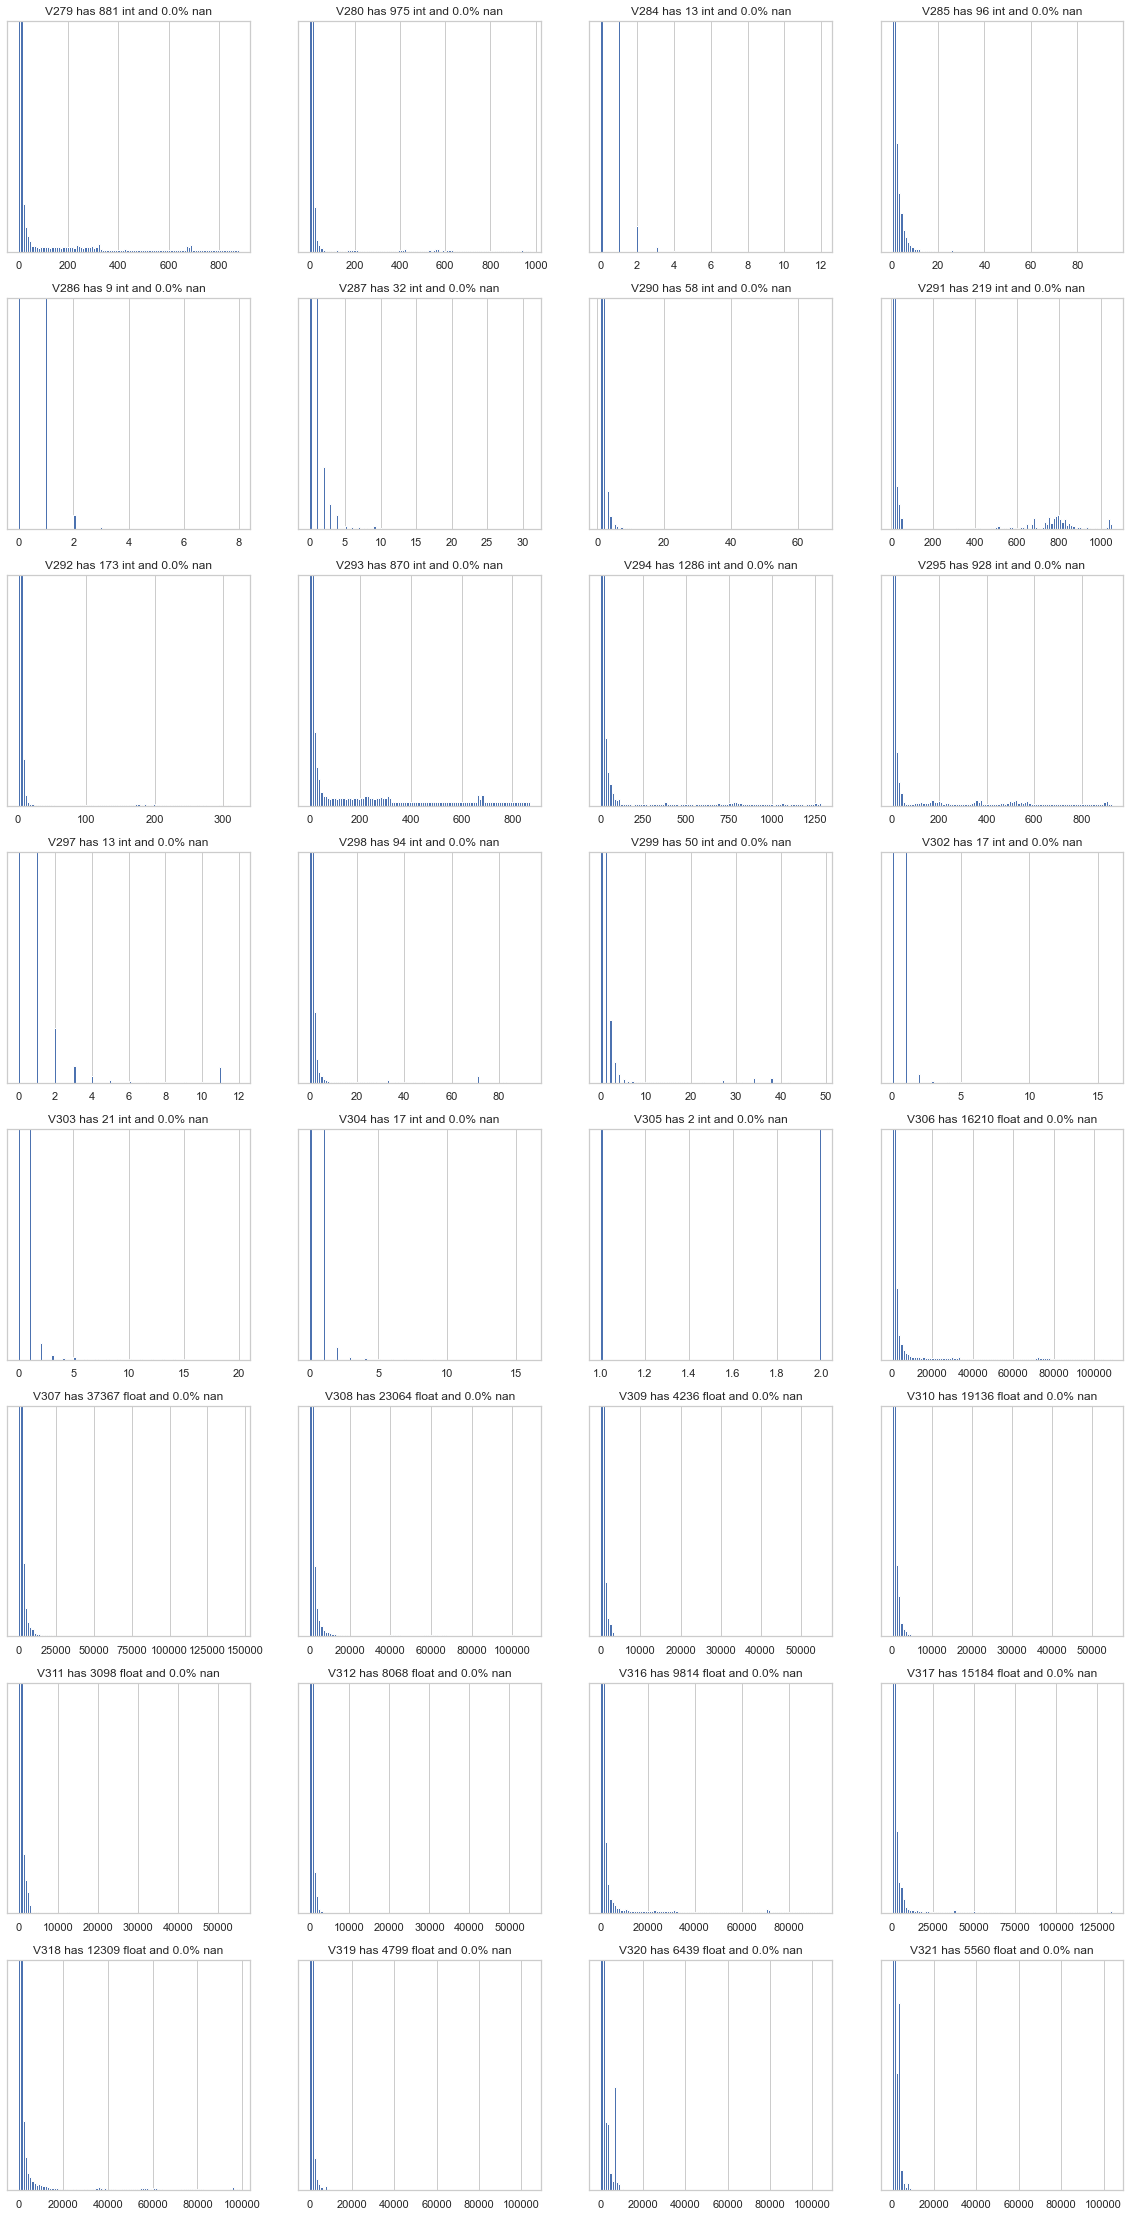

In [33]:
def make_plots(Vs):
    col = 4
    row = len(Vs)//4+1
    plt.figure(figsize=(20,row*5))
    idx = train_df[~train_df[Vs[0]].isna()].index
    for i,v in enumerate(Vs):
        plt.subplot(row,col,i+1)
        n = train_df[v].nunique()
        x = np.sum(train_df.loc[idx,v]!=train_df.loc[idx,v].astype(int))
        y = np.round(100*np.sum(train_df[v].isna())/len(train_df),2)
        t = 'int'
        if x!=0: t = 'float'
        plt.title(v+' has '+str(n)+' '+t+' and '+str(y)+'% nan')
        plt.yticks([])
        h = plt.hist(train_df.loc[idx,v],bins=100)
        if len(h[0])>1: plt.ylim((0,np.sort(h[0])[-2]))
    plt.show()
make_plots(Vs)

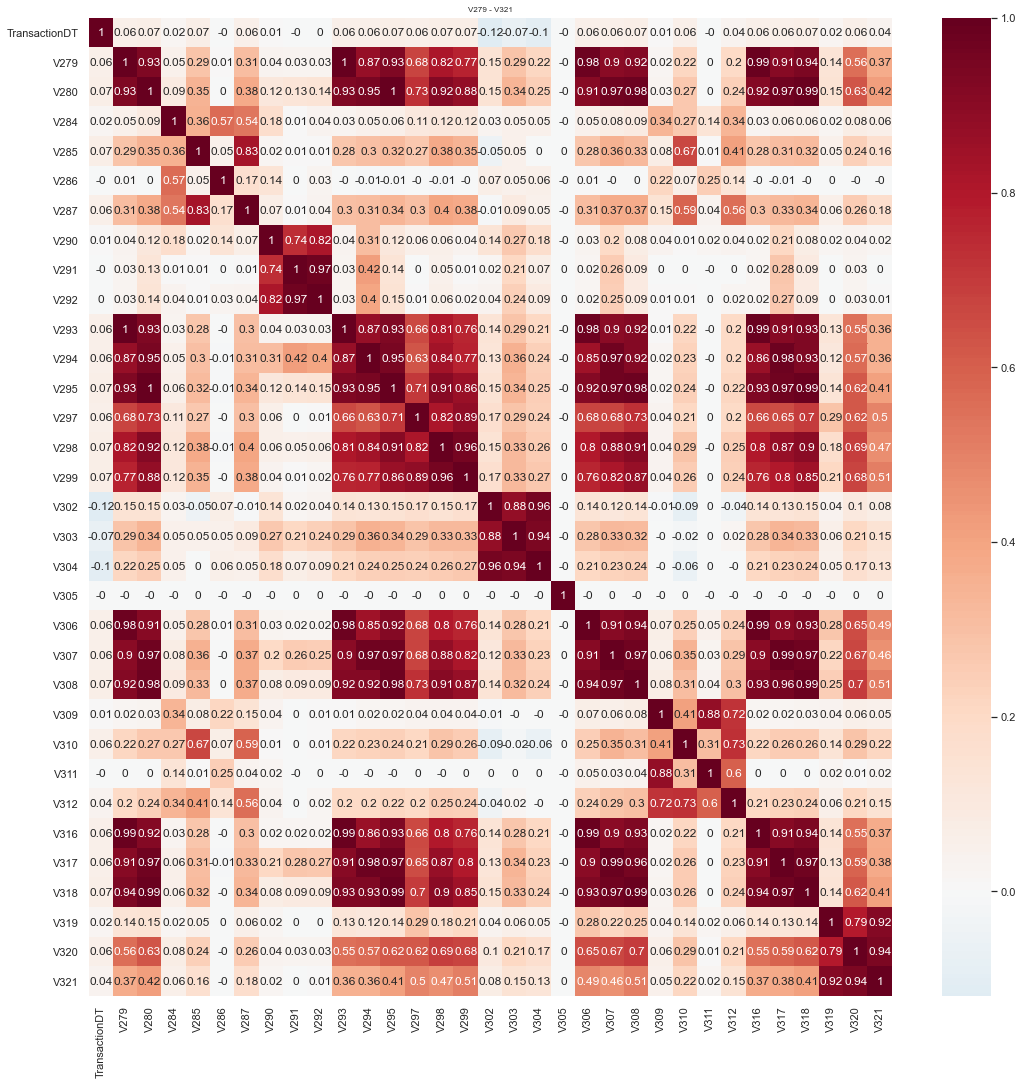

In [34]:
def make_corr(Vs,Vtitle=''):
    cols = ['TransactionDT'] + Vs
    plt.figure(figsize=(18,18))
    sns.heatmap(np.around(train_df[cols].corr(),2), cmap='RdBu_r', annot=True, center=0.0)
    if Vtitle!='': plt.title(Vtitle,fontsize=8)
    else: plt.title(Vs[0]+' - '+Vs[-1],fontsize=8)
    plt.show()
    
make_corr(Vs,Vtitle)

In [35]:
grps = [[279,280,293,294,295,298,299],[284],[285,287],[286],[290,291,292],[297], [302,303,304],[305],[306,307,308,316,317,318],[309,311],[310,312],[319,320,321]]
def reduce_group(grps,c='V'):
    use = []
    for g in grps:
        mx = 0; vx = g[0]
        for gg in g:
            n = train_df[c+str(gg)].nunique()
            if n>mx:
                mx = n
                vx = gg
            #print(str(gg)+'-'+str(n),', ',end='')
        use.append(vx)
        #print()
    print('Use these',use)
reduce_group(grps)

Use these [294, 284, 285, 286, 291, 297, 303, 305, 307, 309, 310, 320]


V1-V11, D11

In [36]:
Vc = ['dayr','isFraud','TransactionAmt','card1','addr1','D1n','D11n']
Vs = nans_groups[279287]
Vtitle = 'V1 - V11, D11'

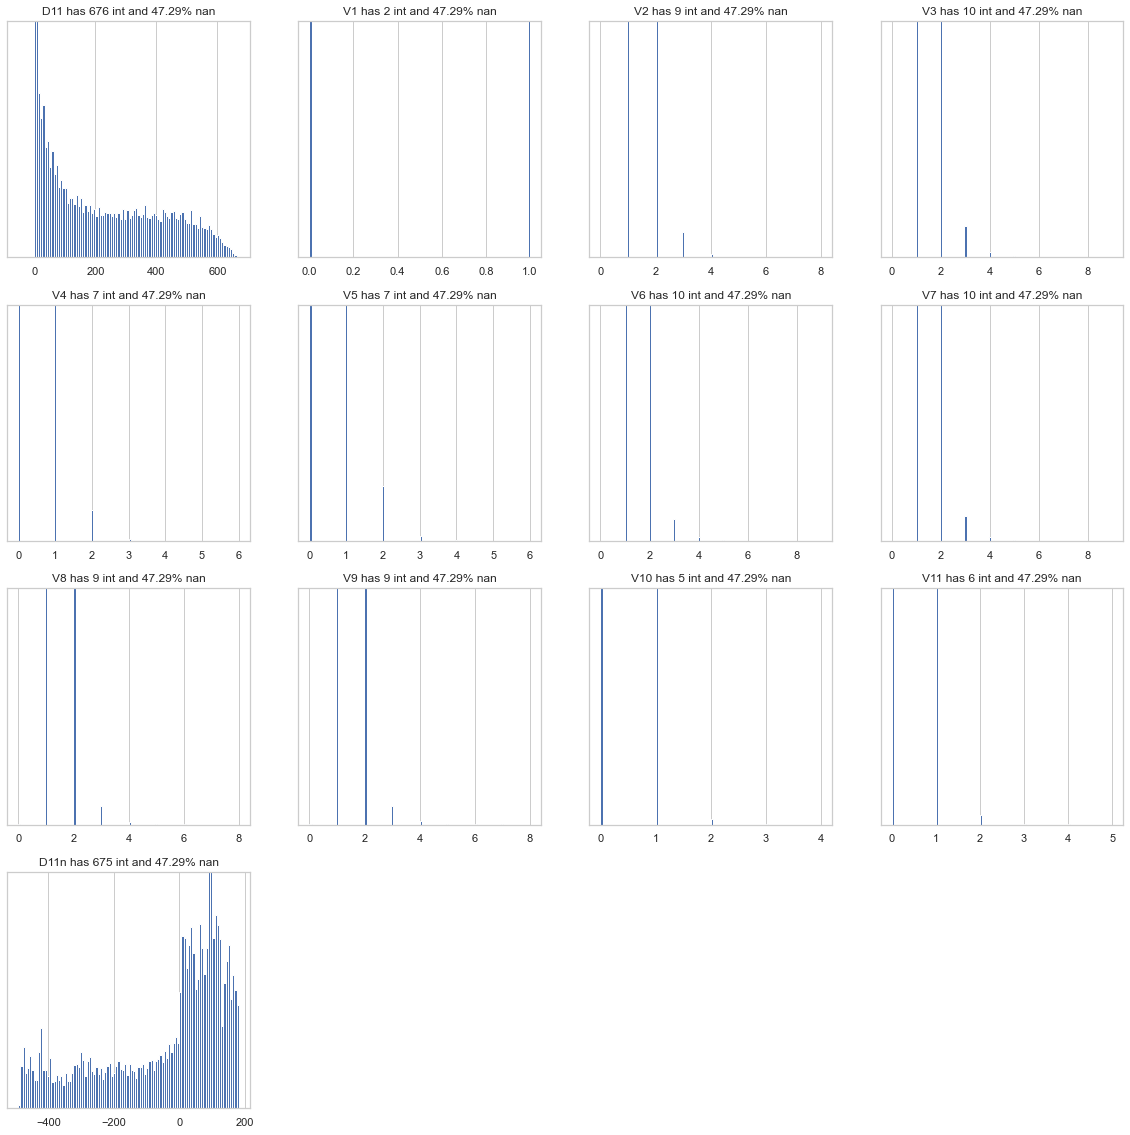

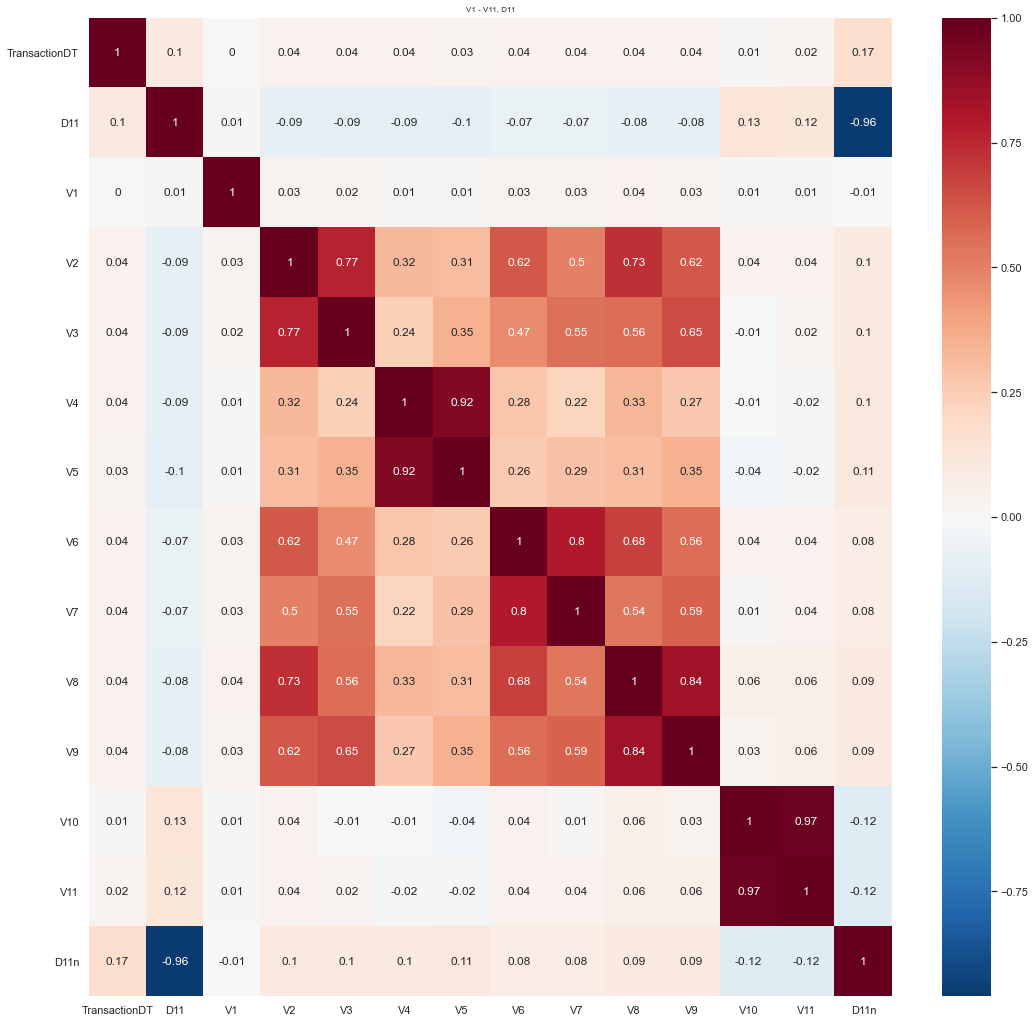

In [37]:
make_plots(Vs)
make_corr(Vs,Vtitle)

In [38]:
grps = [[1],[2,3],[4,5],[6,7],[8,9],[10,11]]
reduce_group(grps)

Use these [1, 3, 4, 6, 8, 11]


### V12 - V34

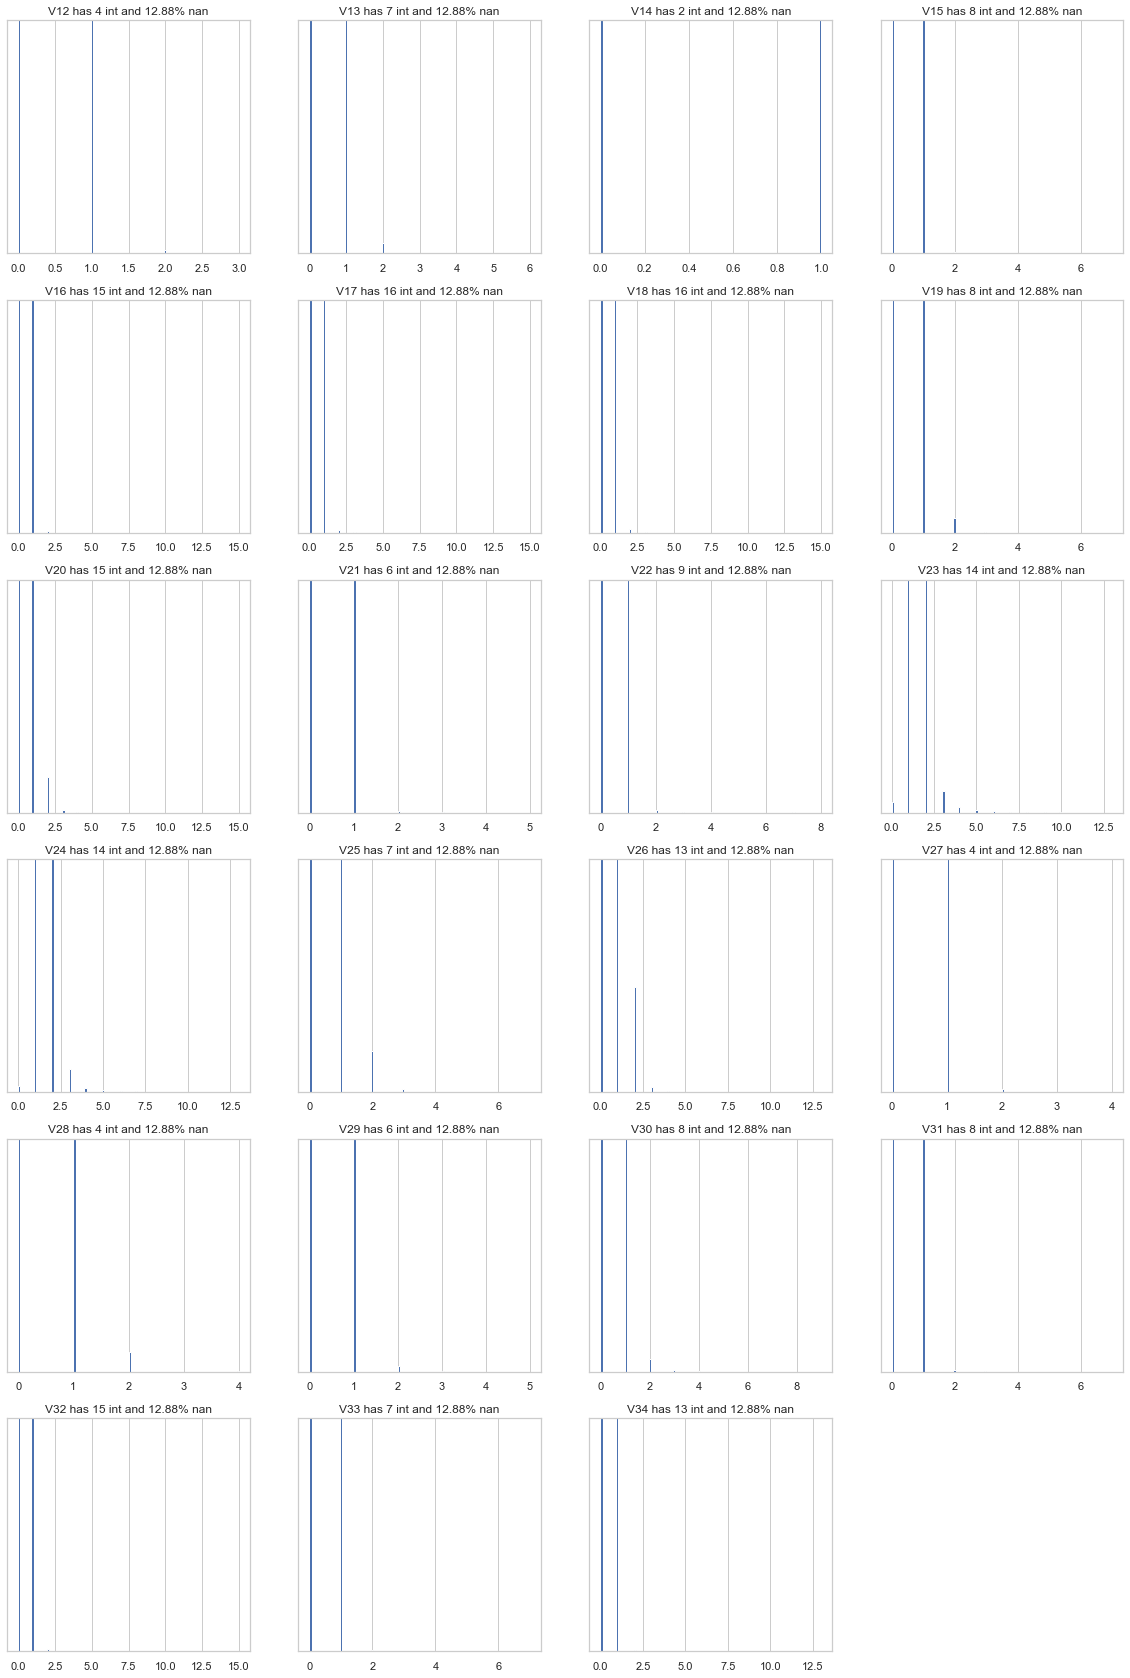

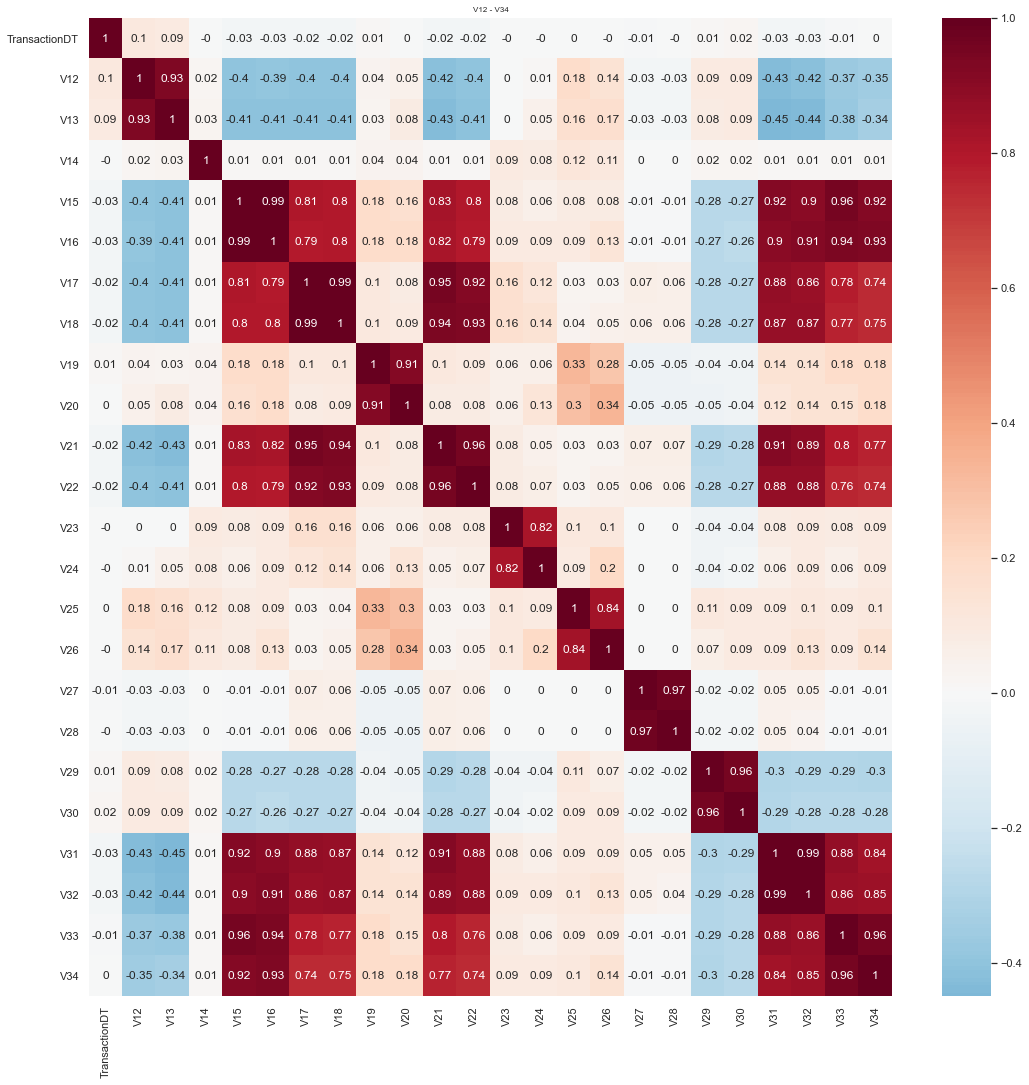

In [39]:
Vs = nans_groups[76073]
make_plots(Vs)
make_corr(Vs)

In [40]:
grps = [[12,13],[14],[15,16,17,18,21,22,31,32,33,34],[19,20],[23,24],[25,26],[27,28],[29,30]]
reduce_group(grps)

Use these [13, 14, 17, 20, 23, 26, 27, 30]


### V35 - V52

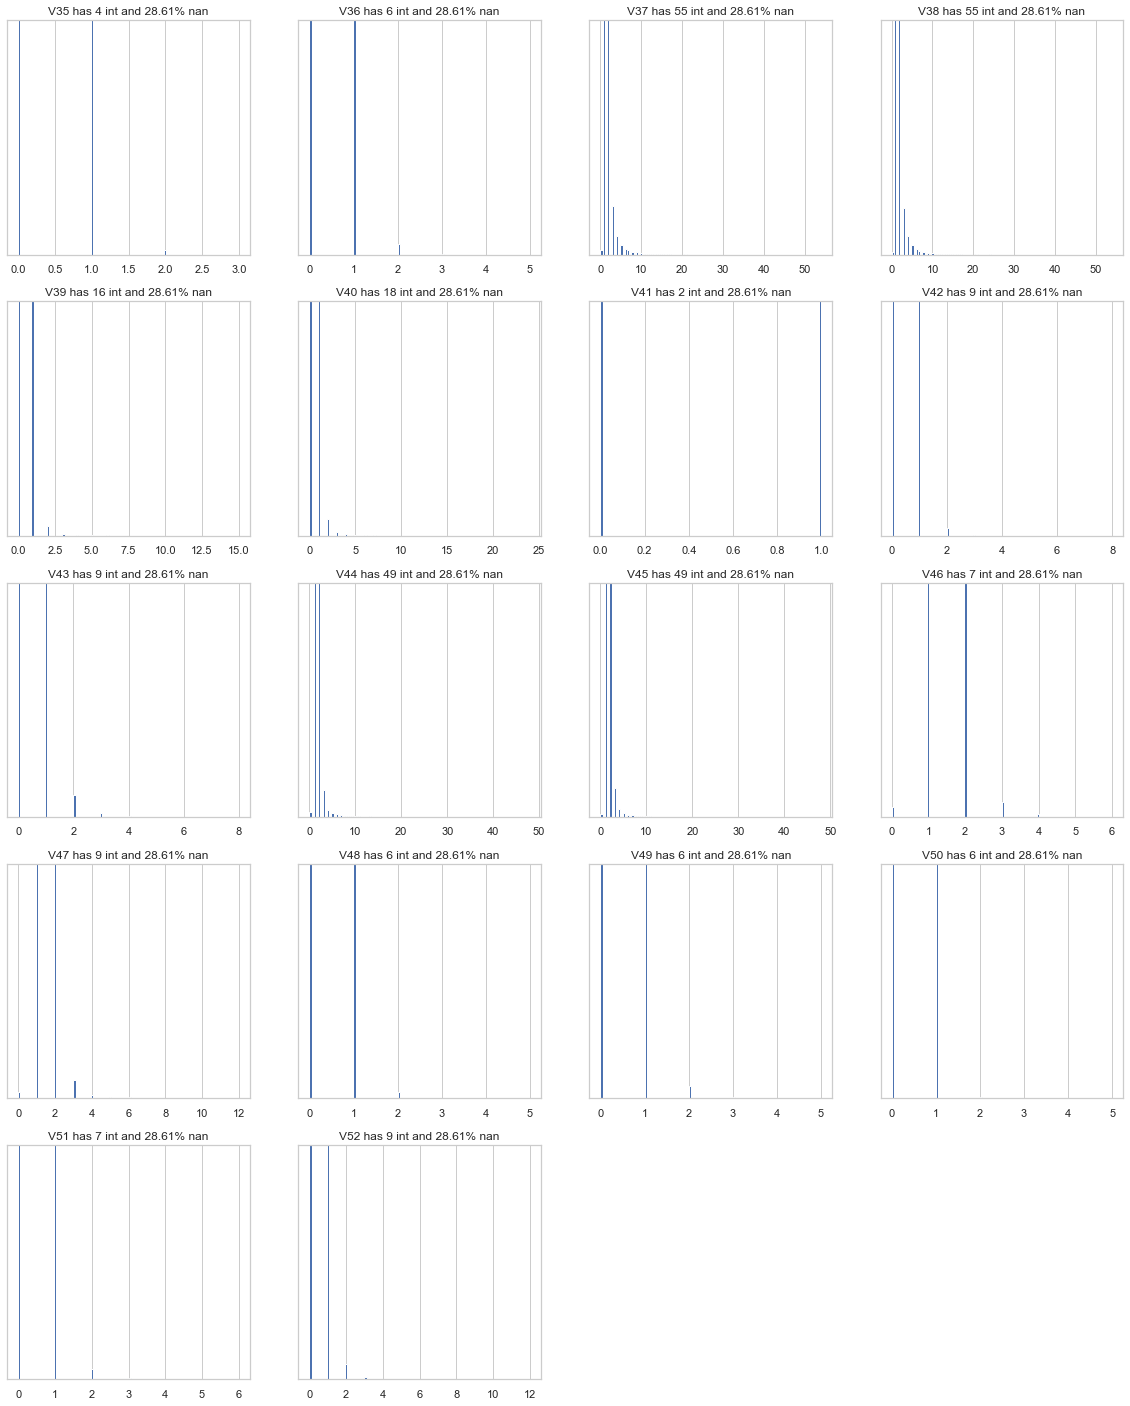

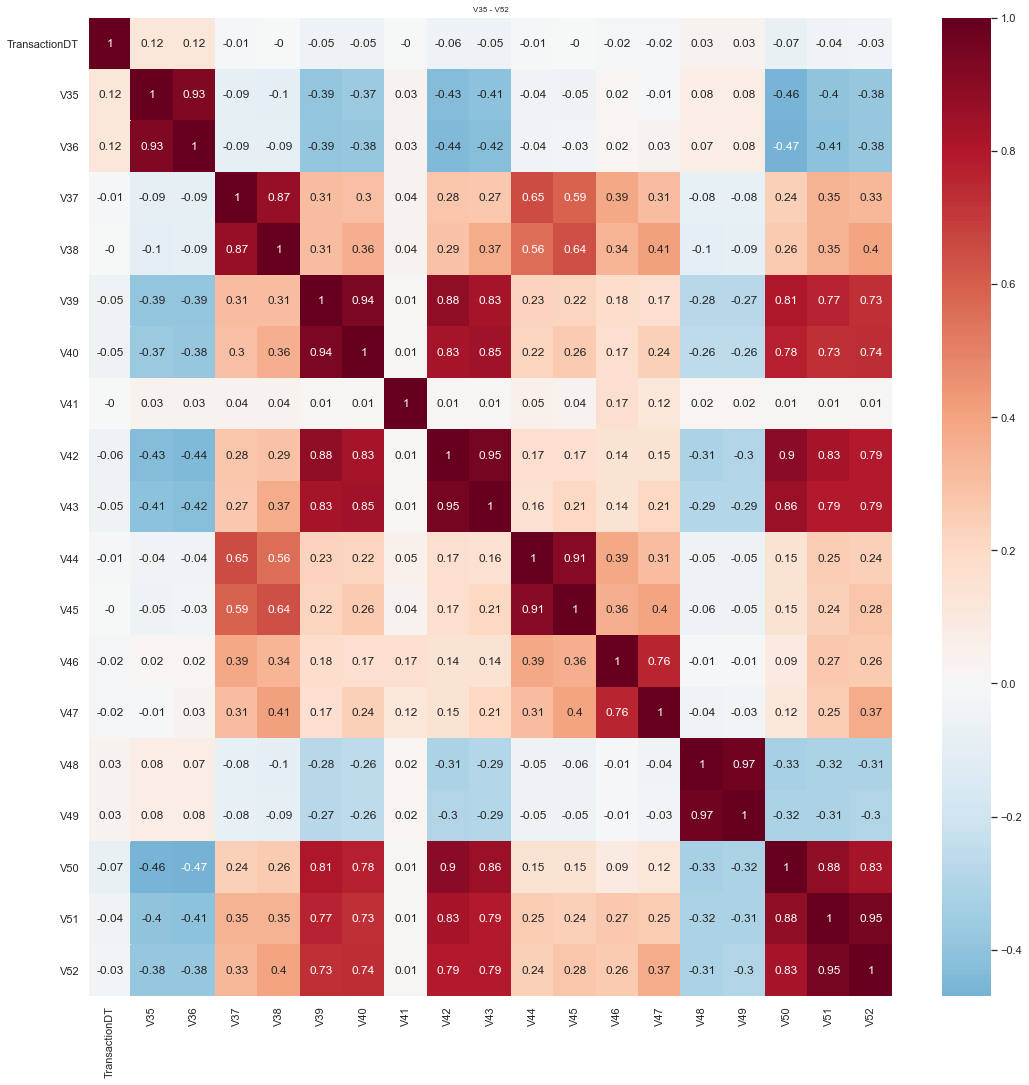

In [41]:
Vs = nans_groups[168969]
make_plots(Vs)
make_corr(Vs)

In [42]:
grps = [[35,36],[37,38],[39,40,42,43,50,51,52],[41],[44,45],[46,47],[48,49]]
reduce_group(grps)

Use these [36, 37, 40, 41, 44, 47, 48]


### V53 - V74

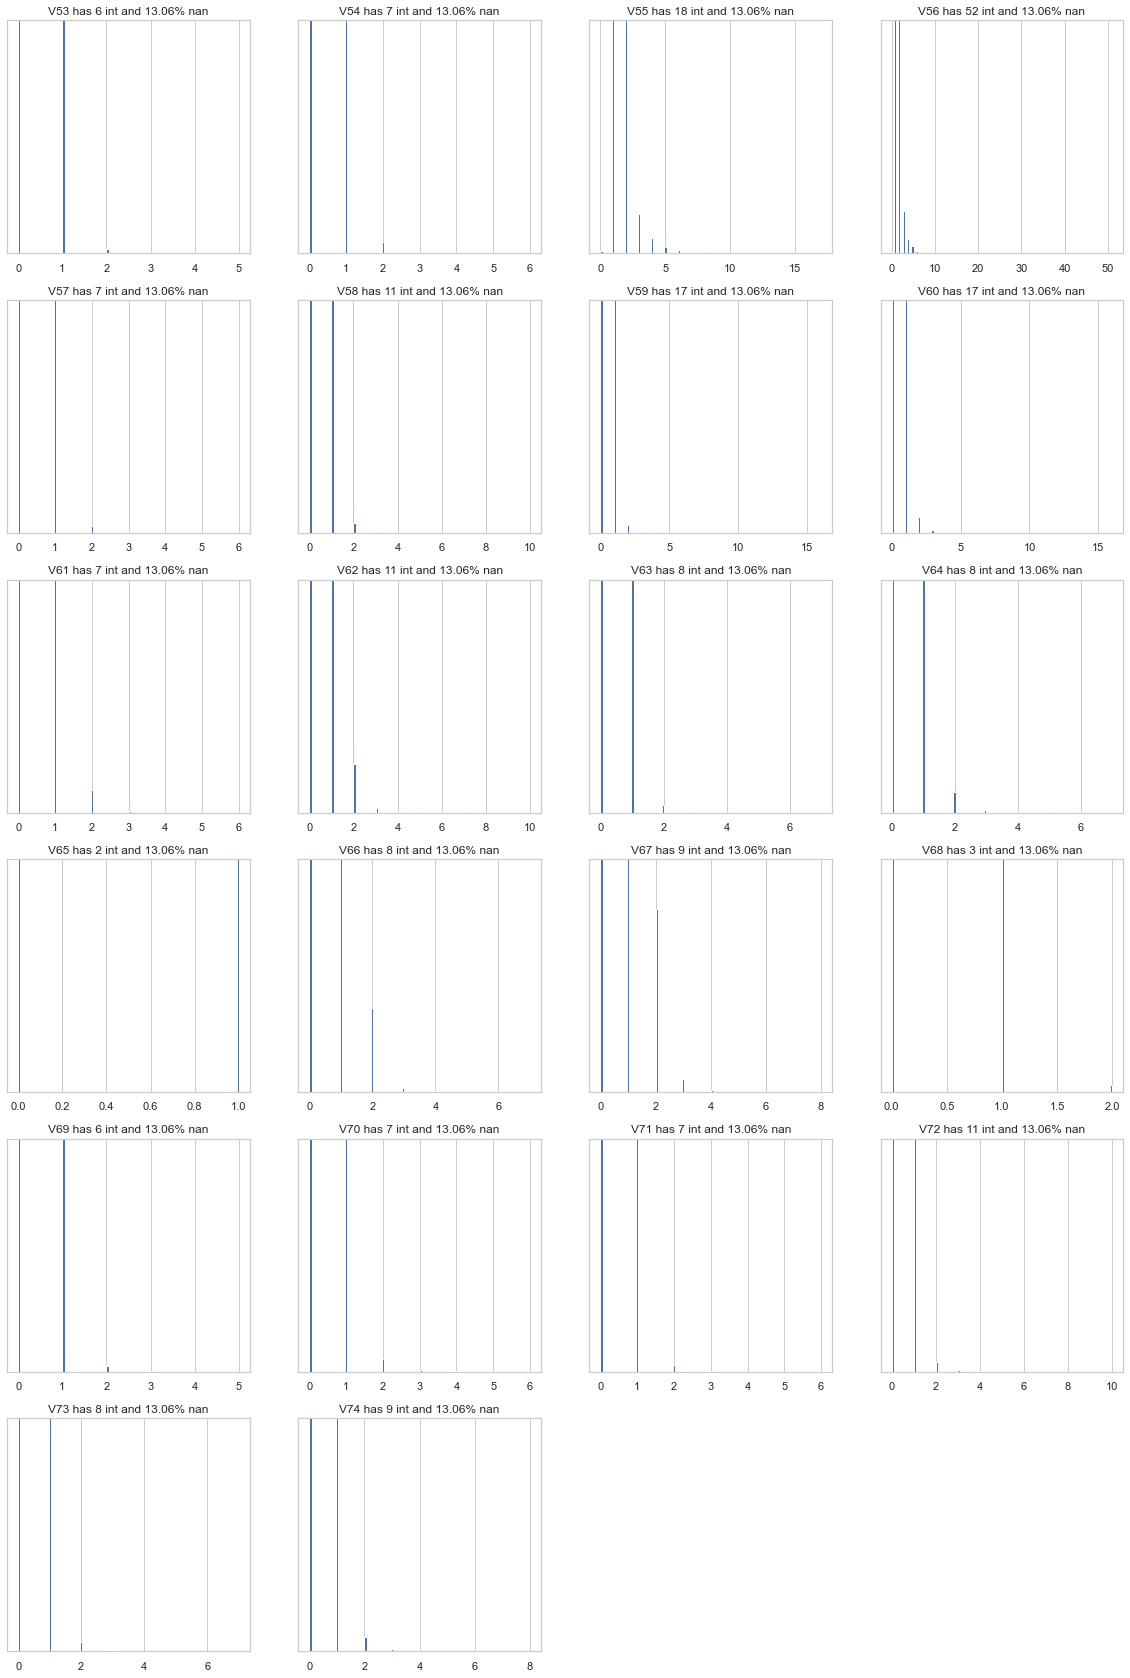

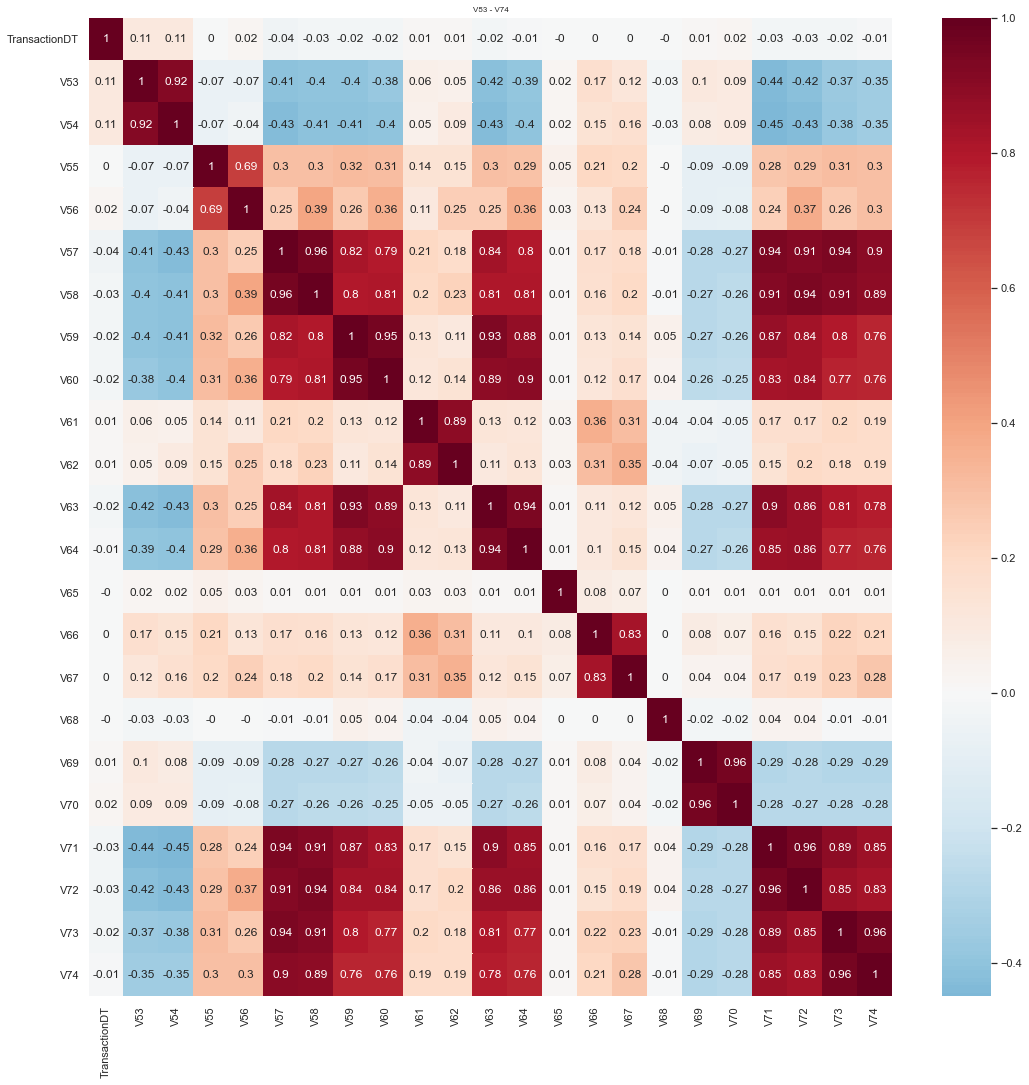

In [43]:
Vs = nans_groups[77096]
make_plots(Vs)
make_corr(Vs)

In [44]:
grps = [[53,54],[55,56],[57,58,59,60,63,64,71,72,73,74],[61,62],[65],[66,67],[68],[69,70]]
reduce_group(grps)

Use these [54, 56, 59, 62, 65, 67, 68, 70]


### V75 - V94

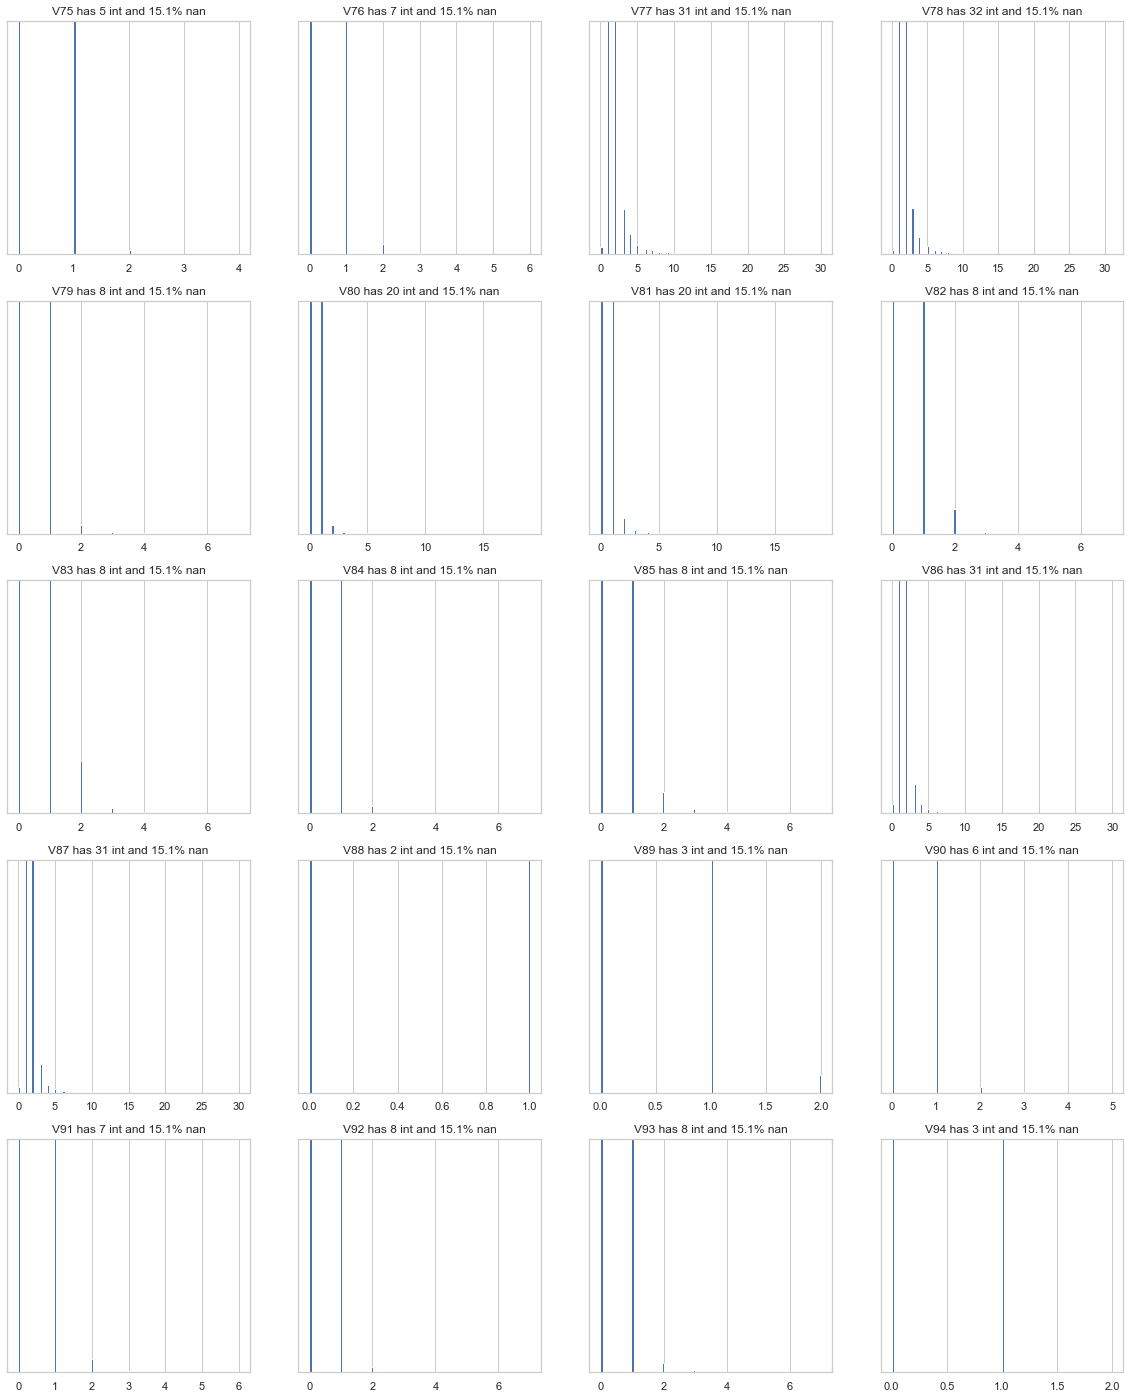

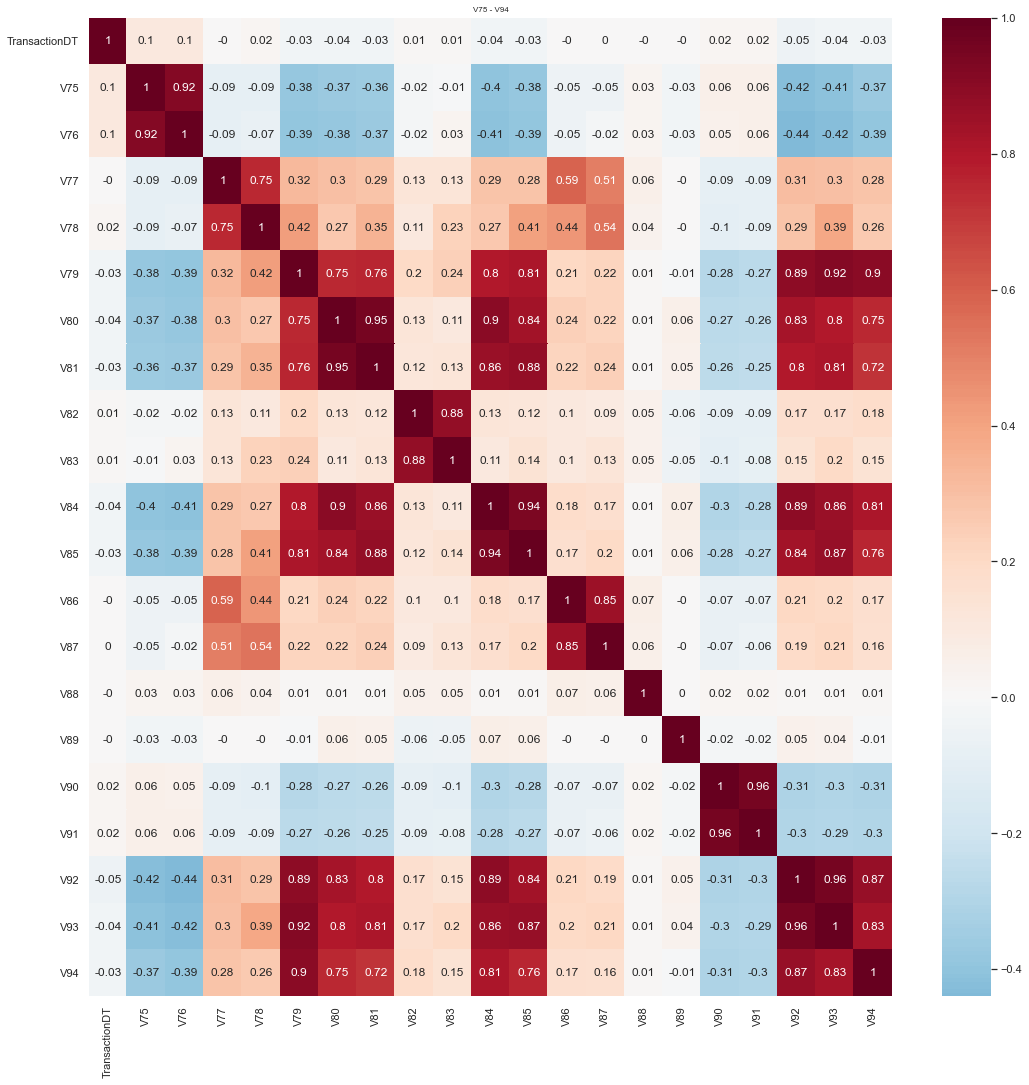

In [45]:
Vs = nans_groups[89164]
make_plots(Vs)
make_corr(Vs)

In [46]:
grps = [[75,76],[77,78],[79,80,81,84,85,92,93,94],[82,83],[86,87],[88],[89],[90,91]]
reduce_group(grps)

Use these [76, 78, 80, 82, 86, 88, 89, 91]


### V95 - V137

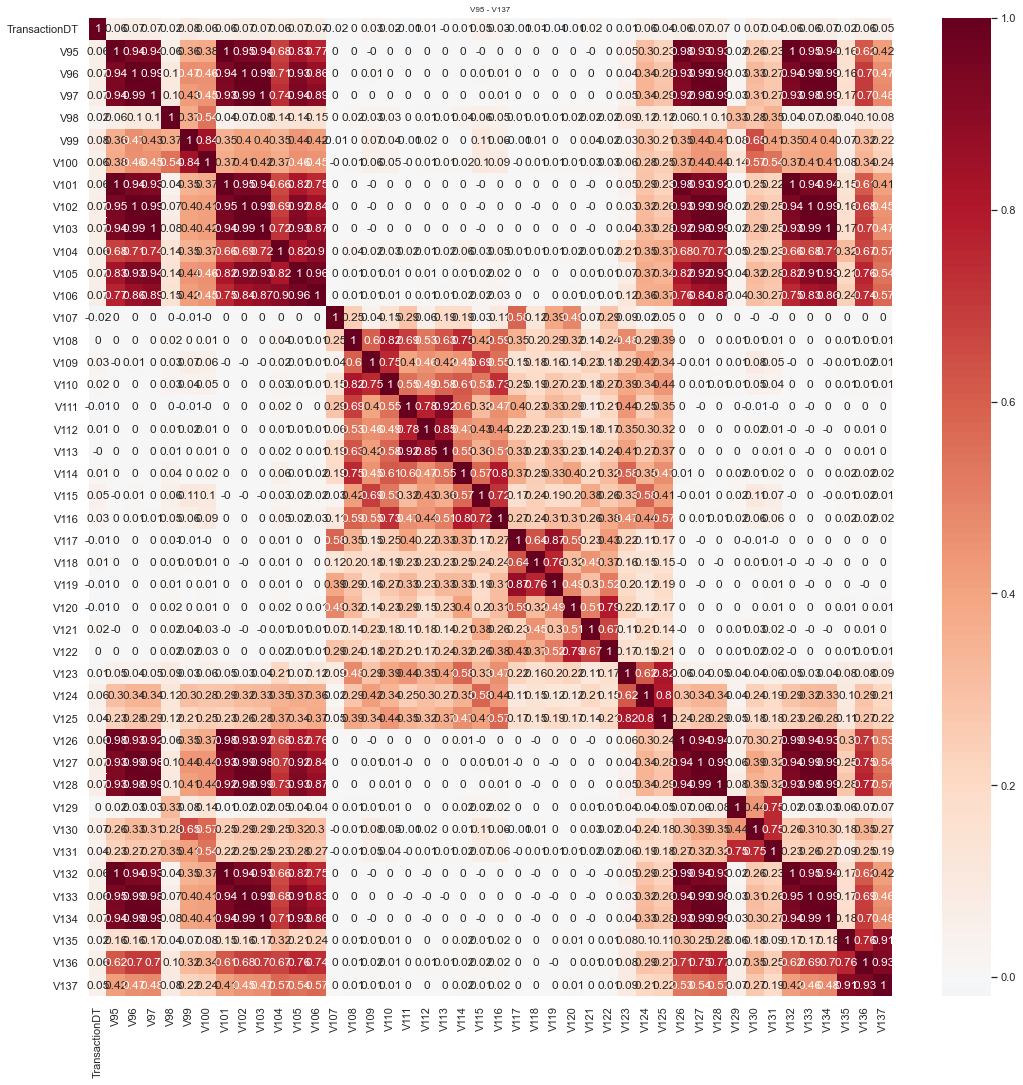

In [47]:
Vs = nans_groups[314]
make_corr(Vs)

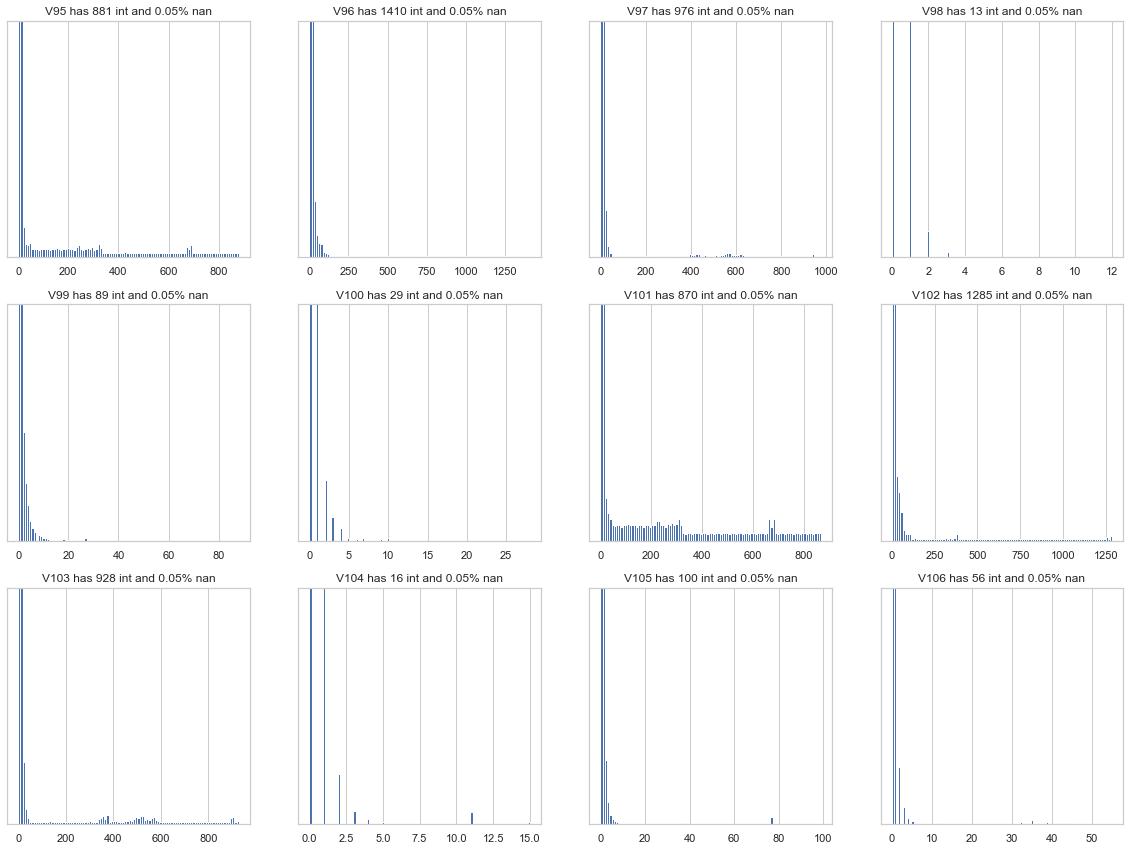

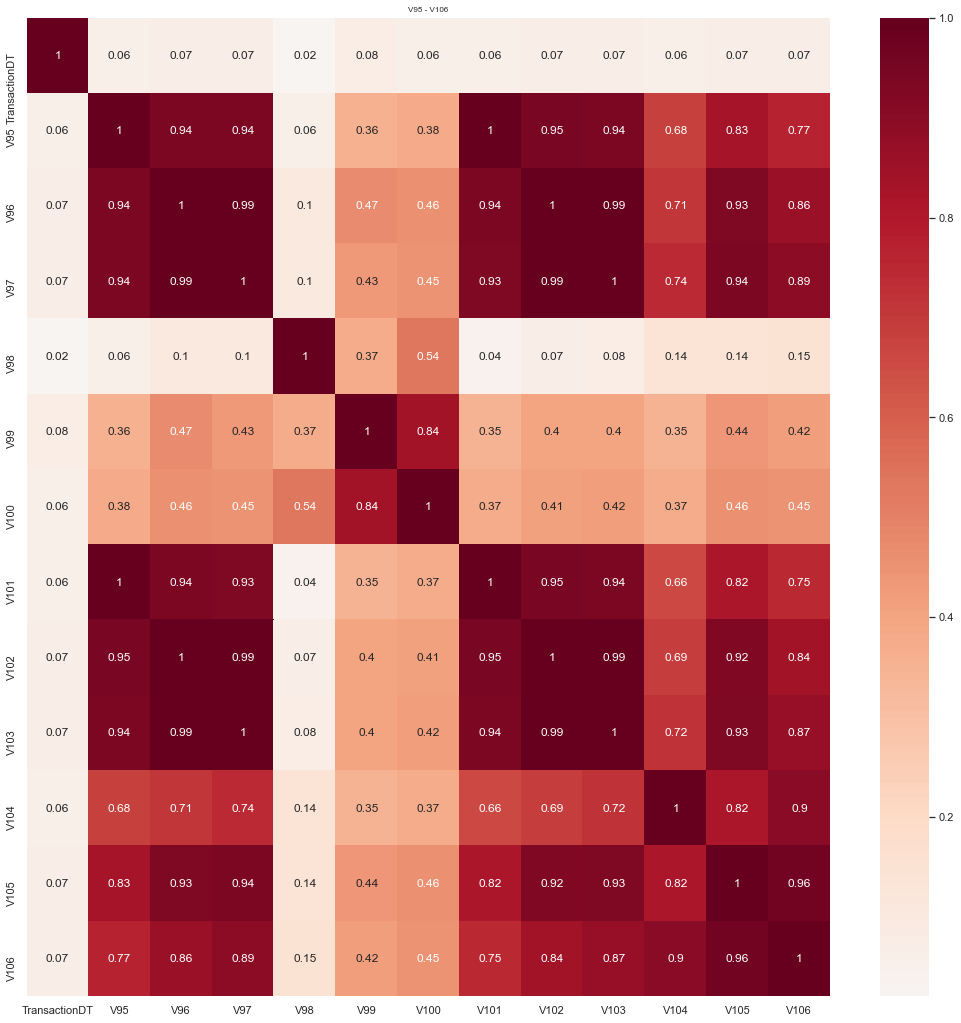

In [48]:
Vs = ['V'+str(x) for x in range(95,107)]
make_plots(Vs)
make_corr(Vs)

In [49]:
grps = [[95,96,97,101,102,103,105,106],[98],[99,100],[104]]
reduce_group(grps)

Use these [96, 98, 99, 104]


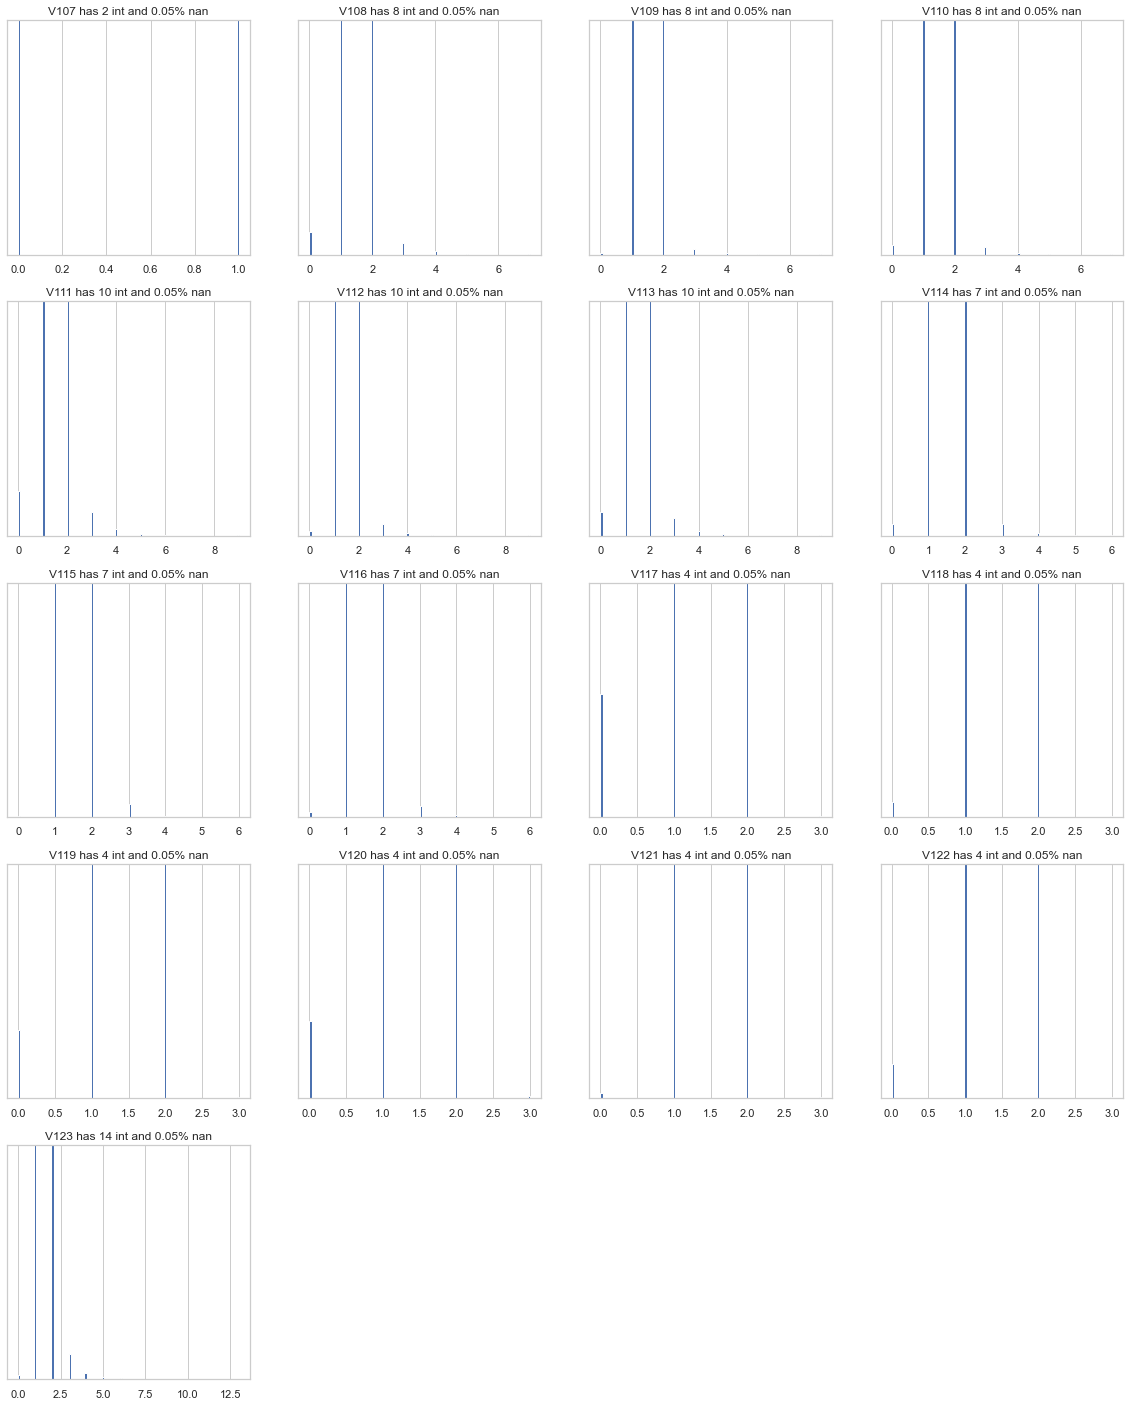

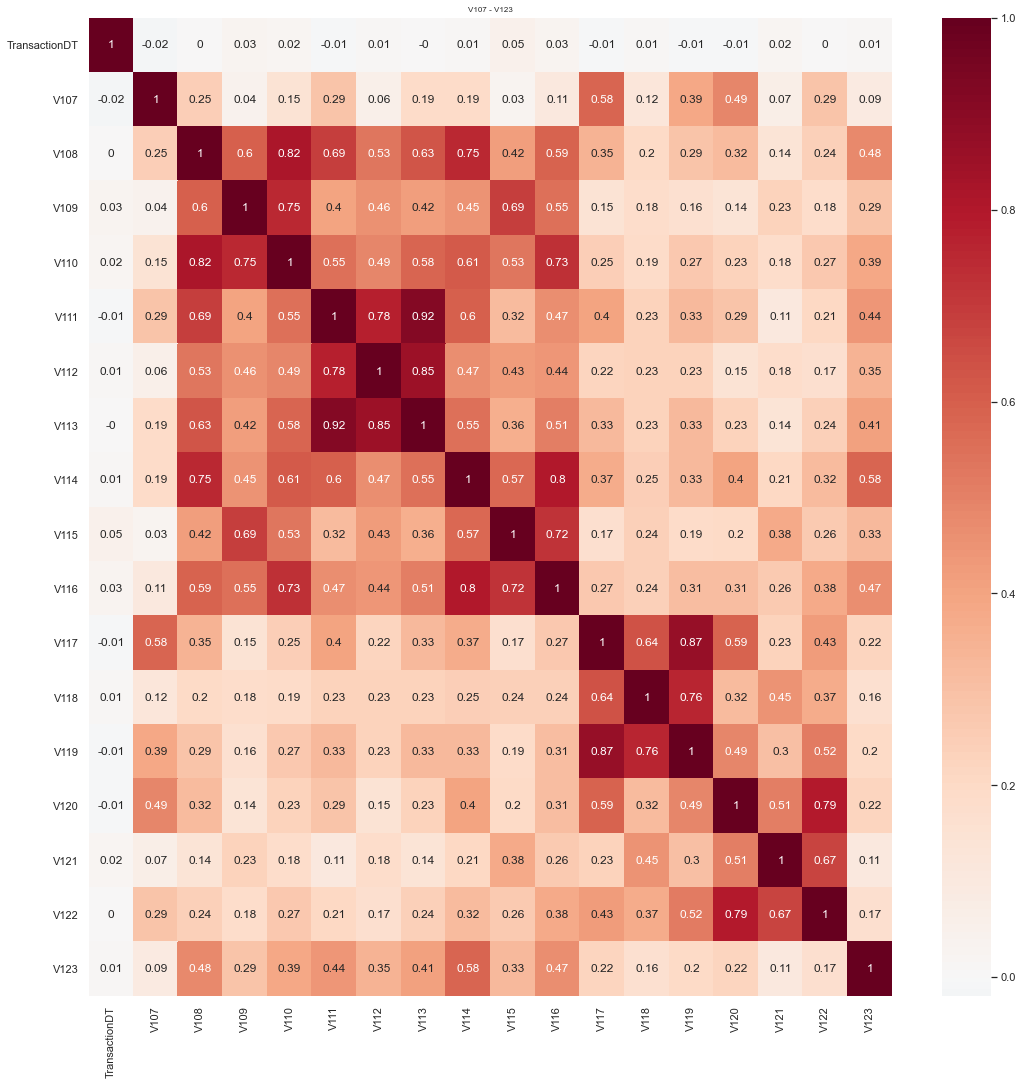

In [50]:
Vs = ['V'+str(x) for x in range(107,124)]
make_plots(Vs)
make_corr(Vs)

In [51]:
grps = [[107],[108,109,110,114],[111,112,113],[115,116],[117,118,119],[120,122],[121],[123]]
reduce_group(grps)

Use these [107, 108, 111, 115, 117, 120, 121, 123]


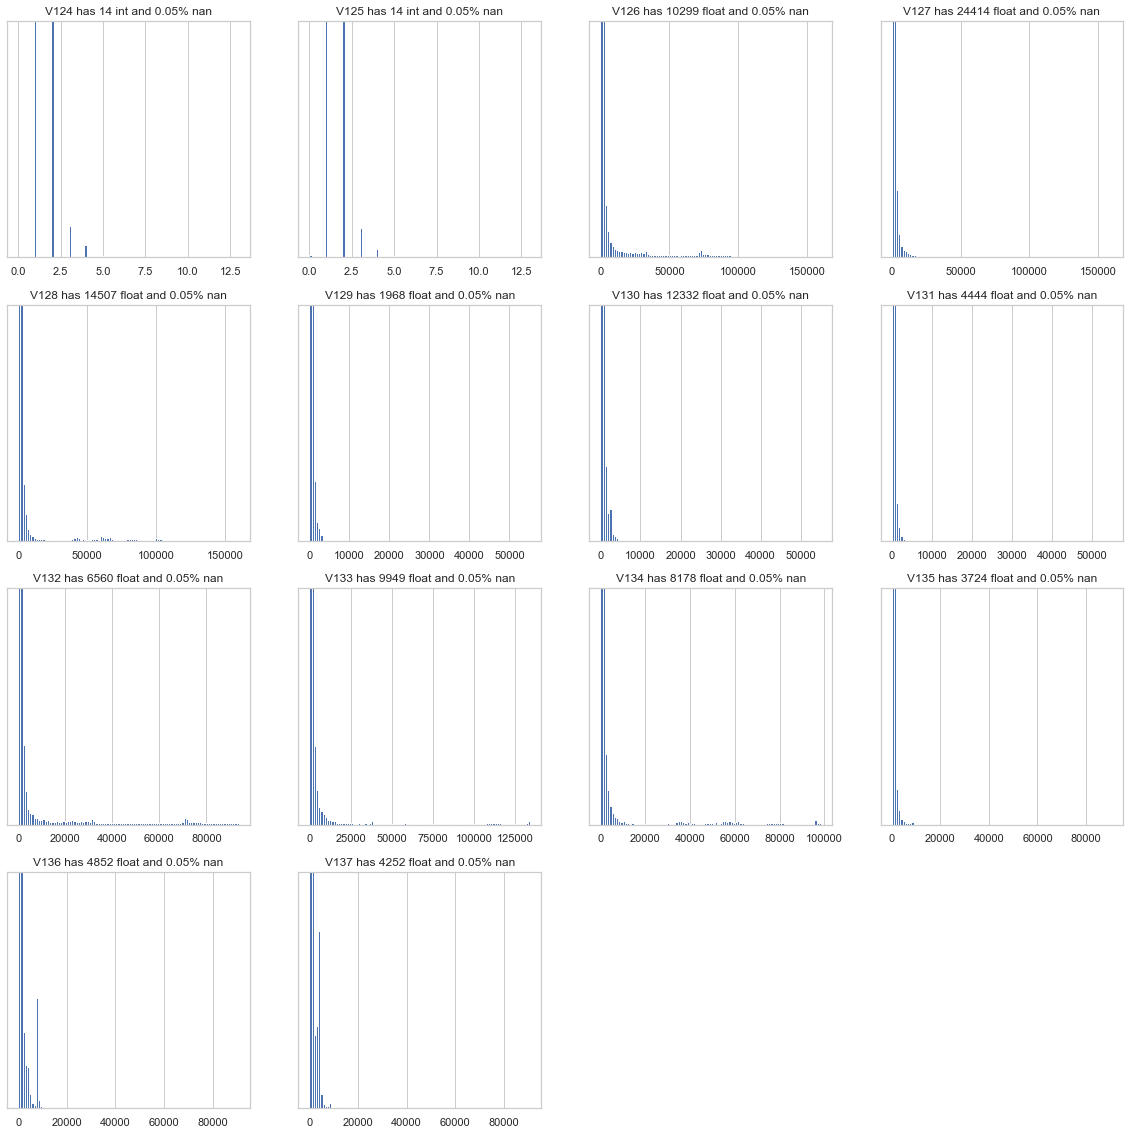

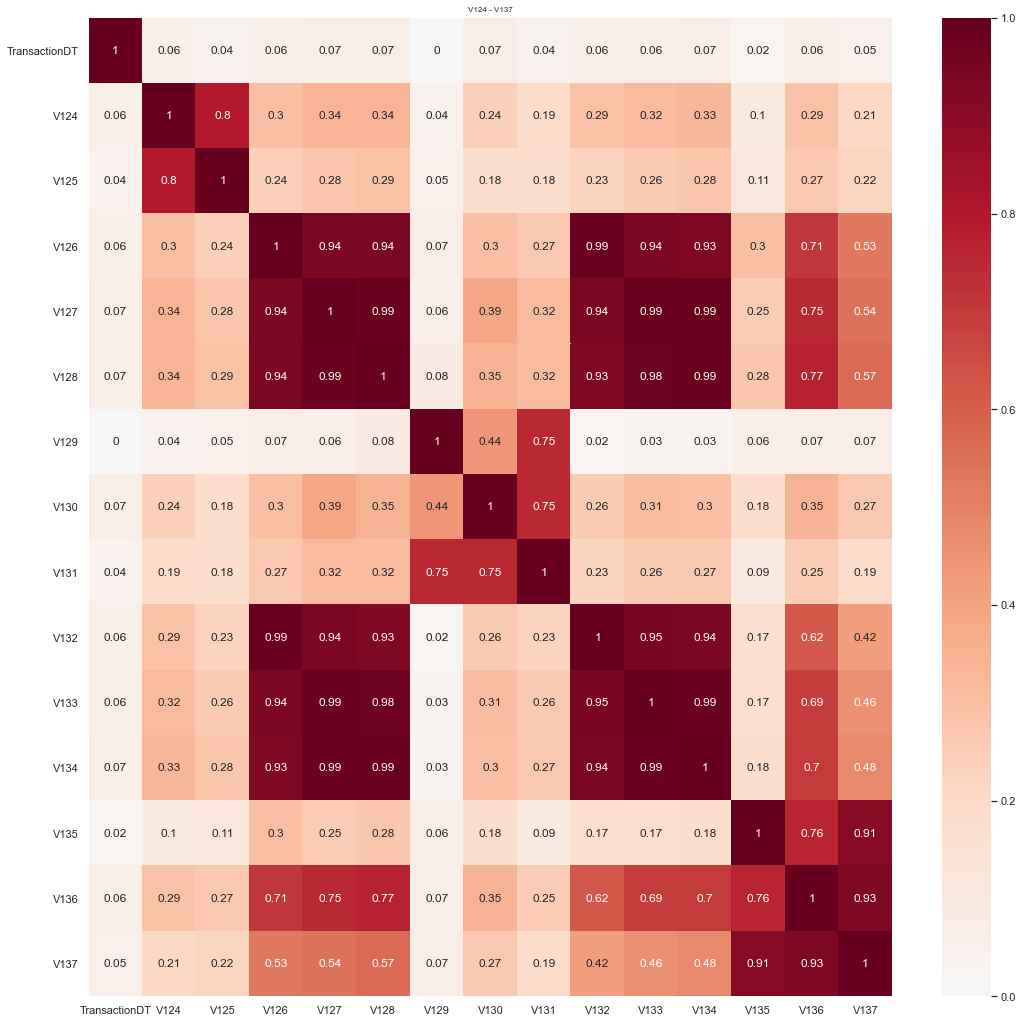

In [52]:
Vs = ['V'+str(x) for x in range(124,138)]
make_plots(Vs)
make_corr(Vs)

In [53]:
grps = [[124,125],[126,127,128,132,133,134],[129],[130,131],[135,136,137]]
reduce_group(grps)

Use these [124, 127, 129, 130, 136]


### V138 ~ V163

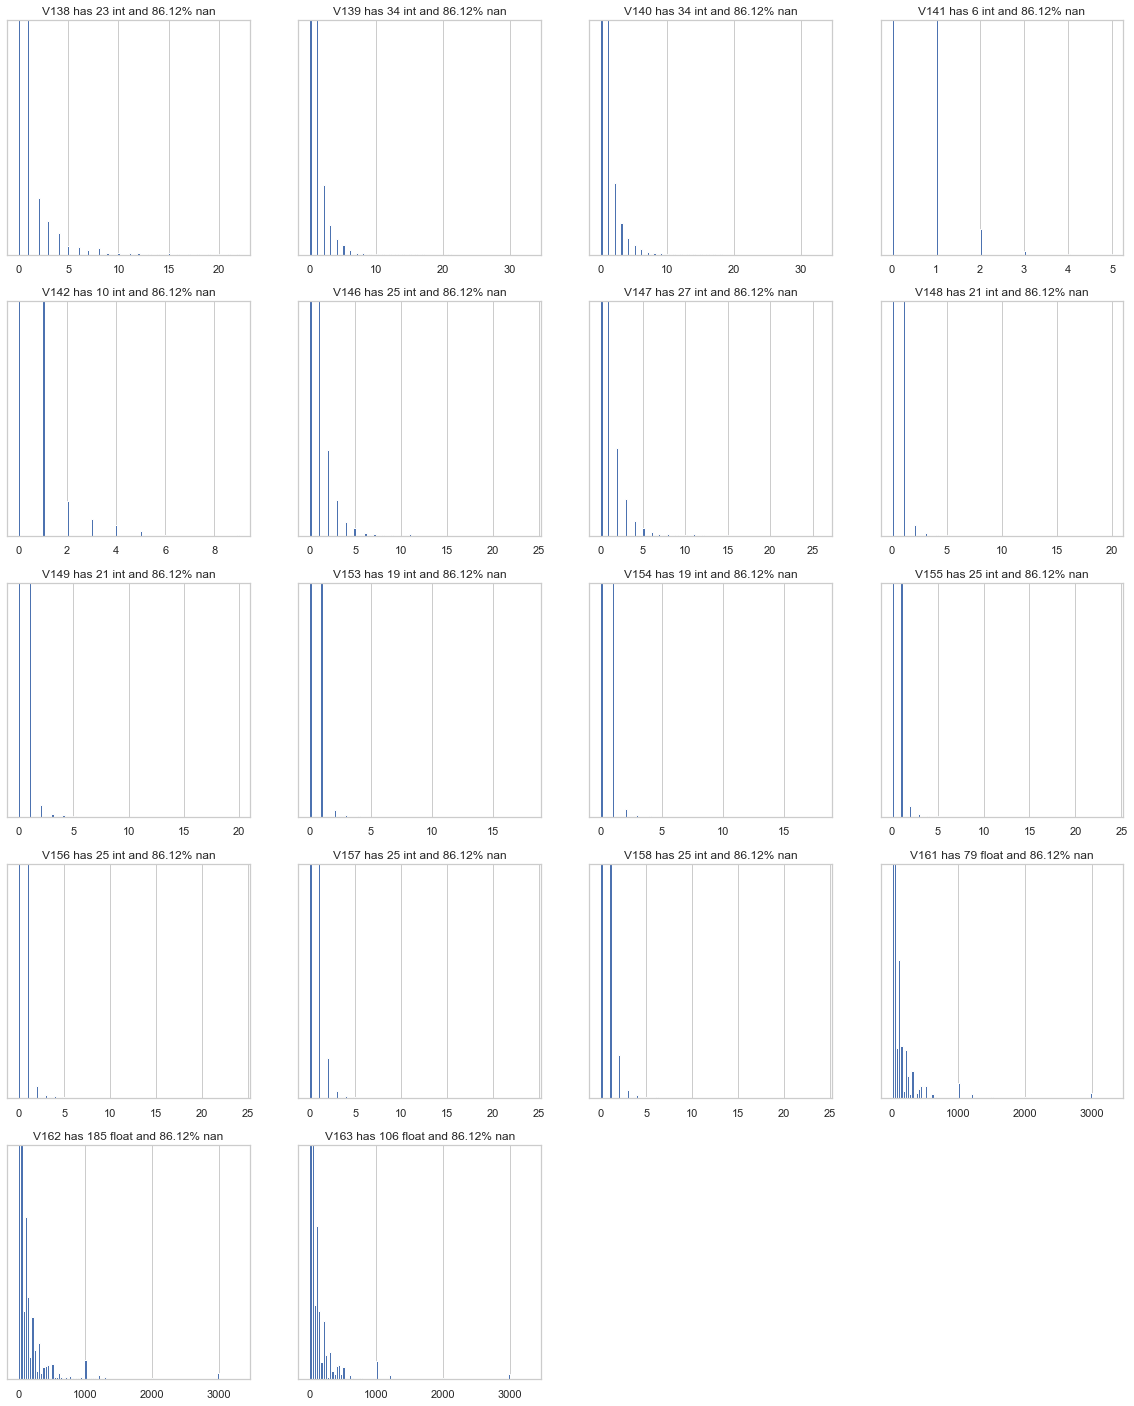

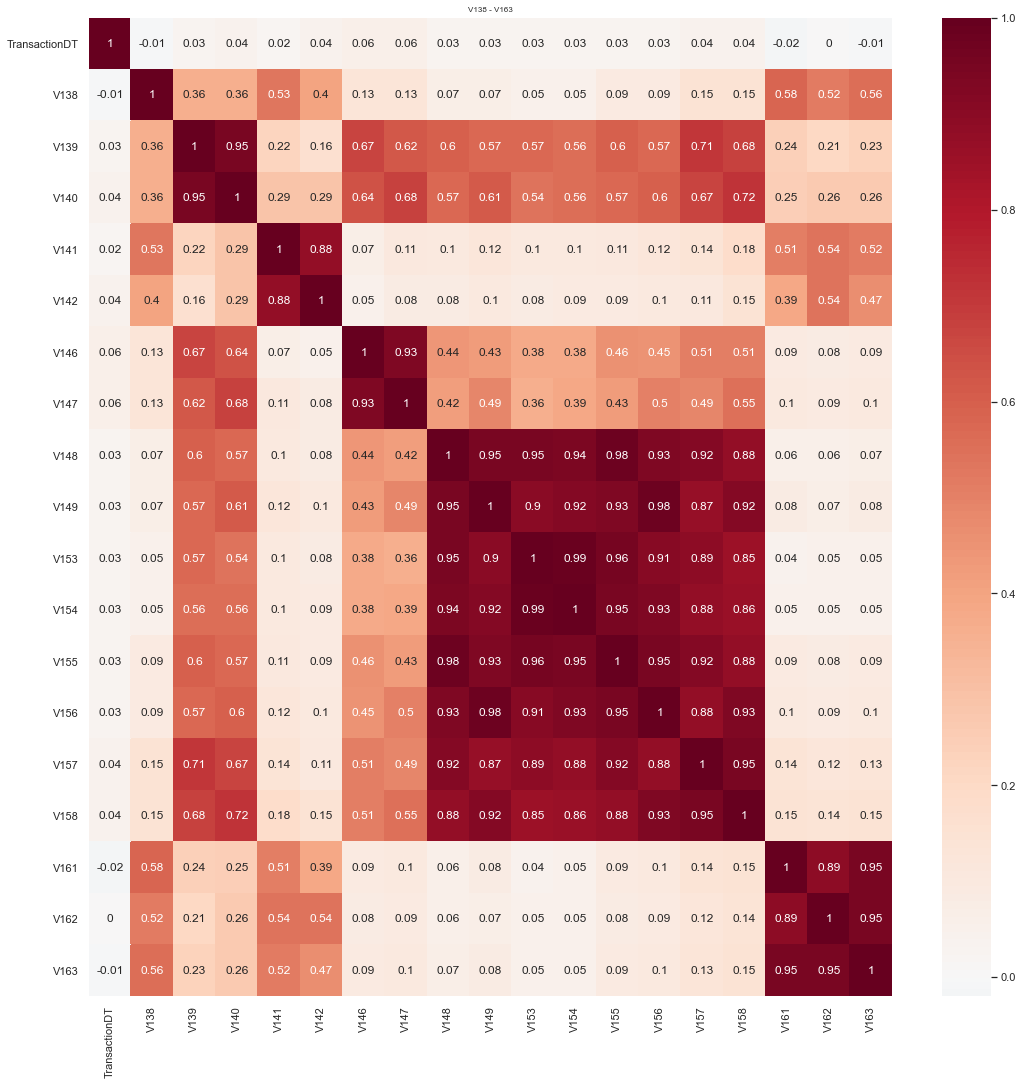

In [54]:
Vs = nans_groups[508595]
make_plots(Vs)
make_corr(Vs)

In [55]:
grps = [[138],[139,140],[141,142],[146,147],[148,149,153,154,156,157,158],[161,162,163]]
reduce_group(grps)

Use these [138, 139, 142, 147, 156, 162]


### V143 ~ V166

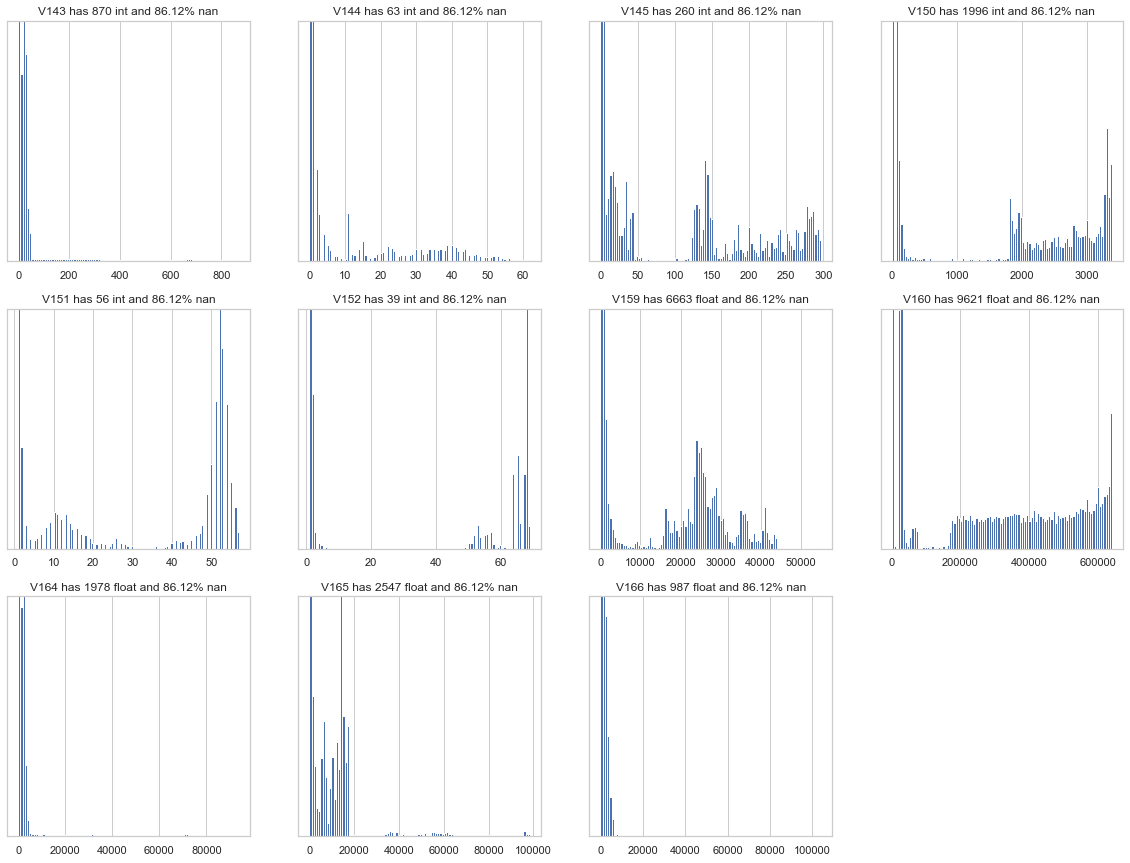

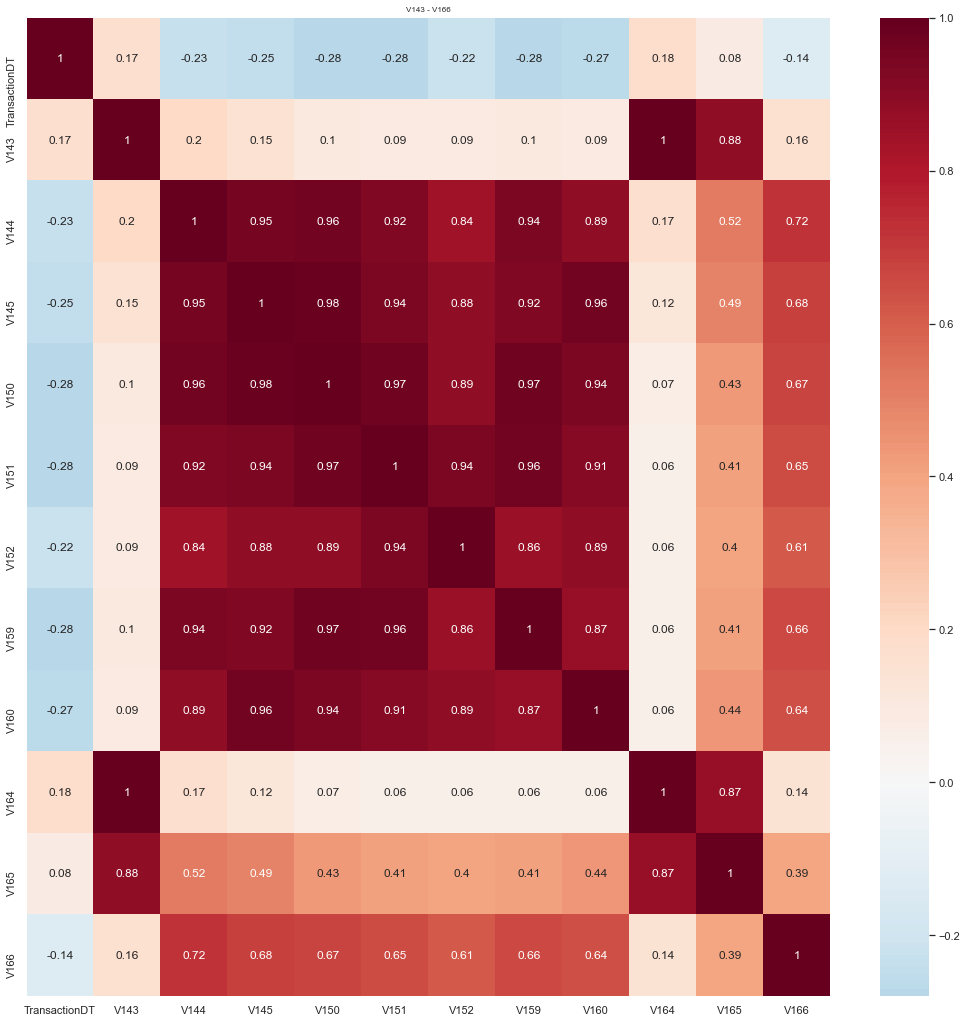

In [56]:
Vs = nans_groups[508589]
make_plots(Vs)
make_corr(Vs)

In [57]:
grps = [[143,164,165],[144,145,150,151,152,159,160],[166]]
reduce_group(grps)

Use these [165, 160, 166]


### V167 ~ V216

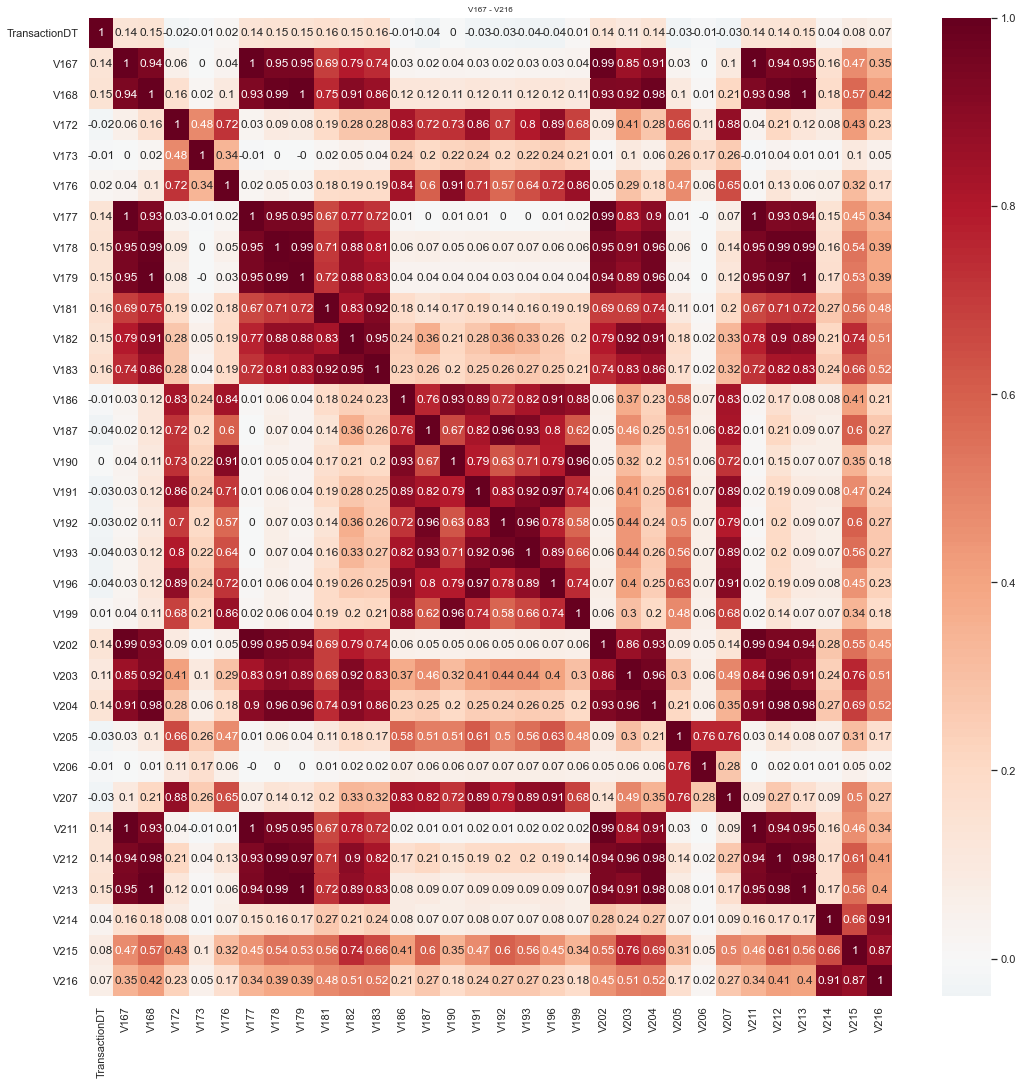

In [58]:
Vs = [x for x in nans_groups[450909]]
make_corr(Vs)

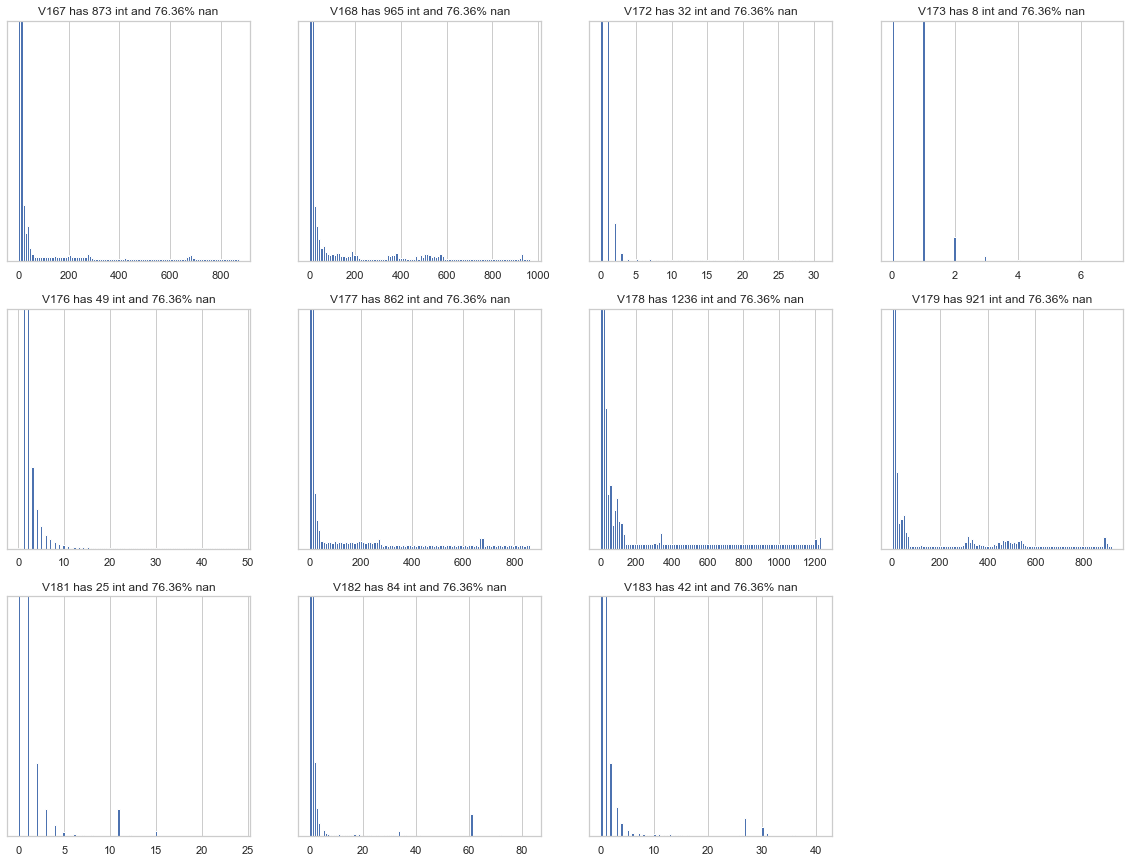

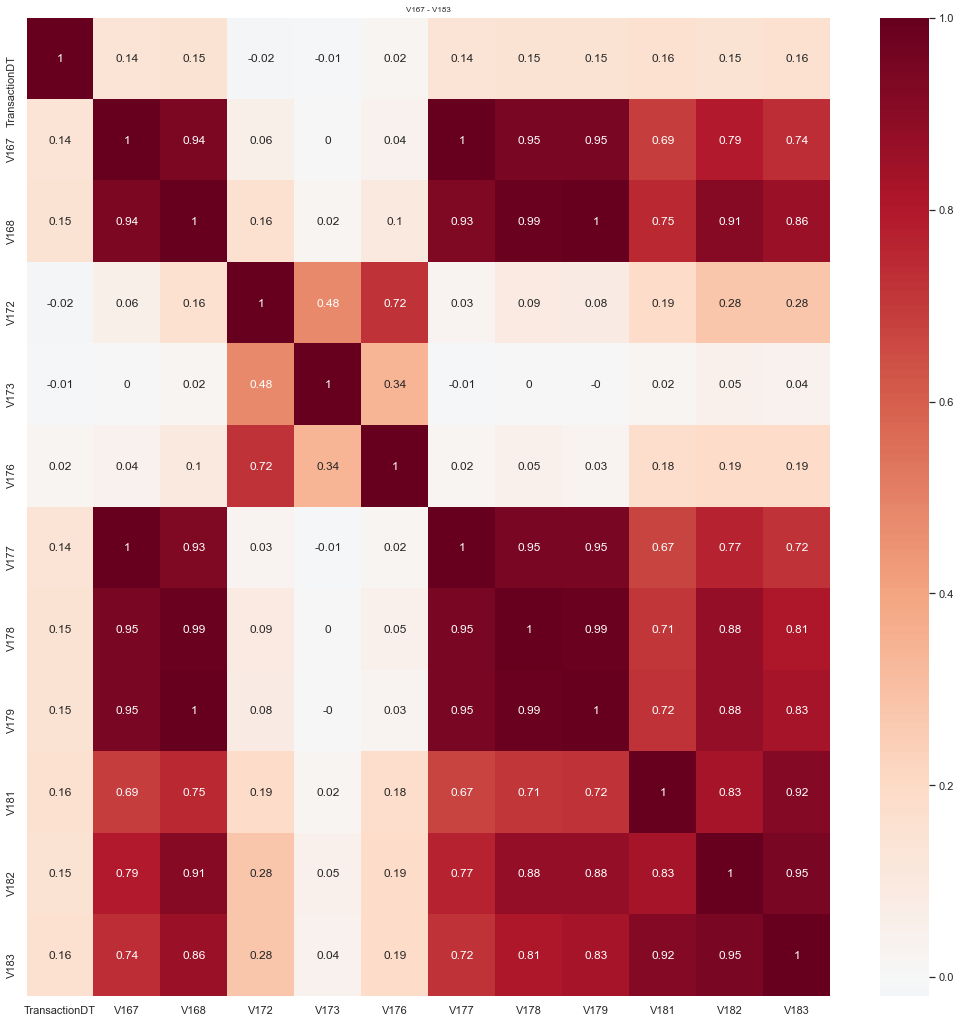

In [59]:
Vs = [x for x in nans_groups[450909] if int(x[1:])<186]
make_plots(Vs)
make_corr(Vs)

In [60]:
grps = [[167,168,177,178,179],[172,176],[173],[181,182,183]]
reduce_group(grps)

Use these [178, 176, 173, 182]


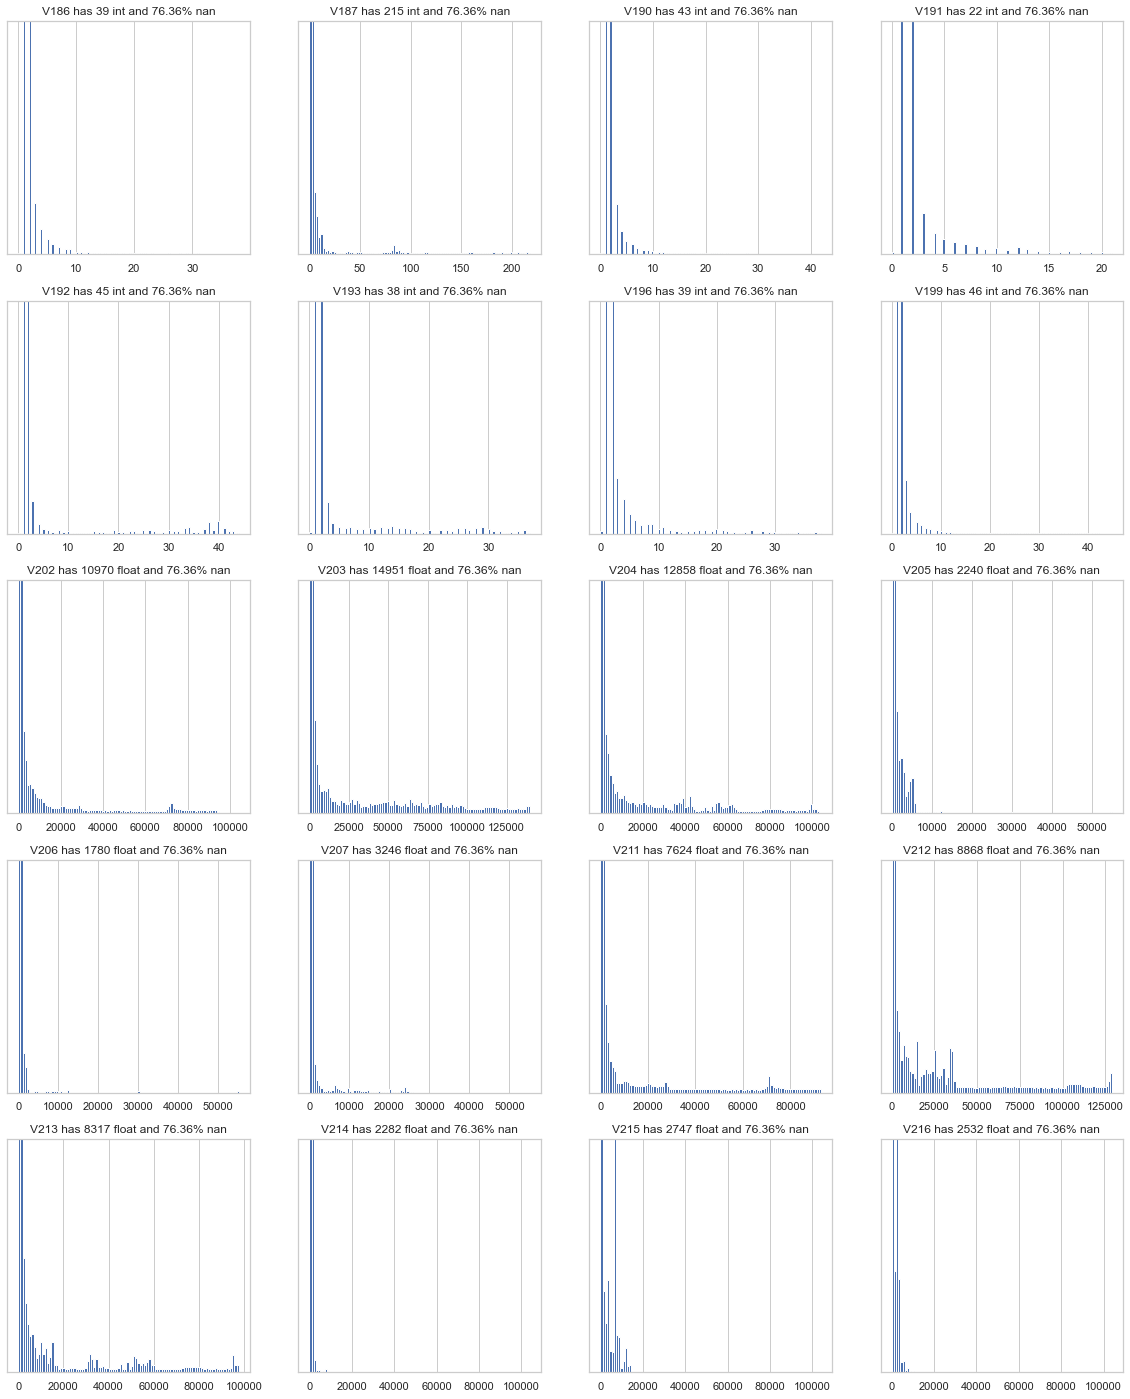

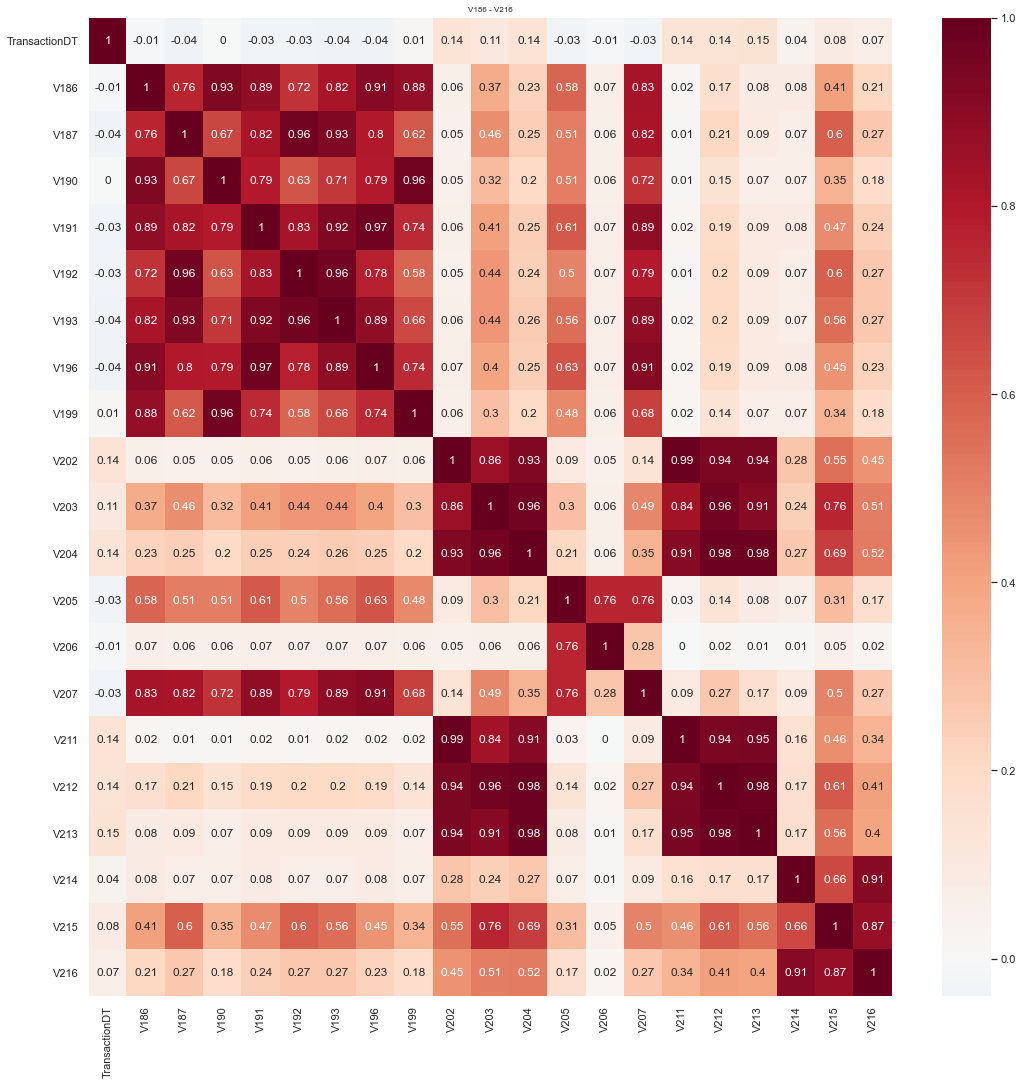

In [61]:
Vs = [x for x in nans_groups[450909] if (int(x[1:])>183)]
make_plots(Vs)
make_corr(Vs)

In [62]:
grps = [[186,187,190,191,192,193,196,199],[202,203,204,211,212,213],[205,206],[207],[214,215,216]]
reduce_group(grps)

Use these [187, 203, 205, 207, 215]


### V169 ~ V210

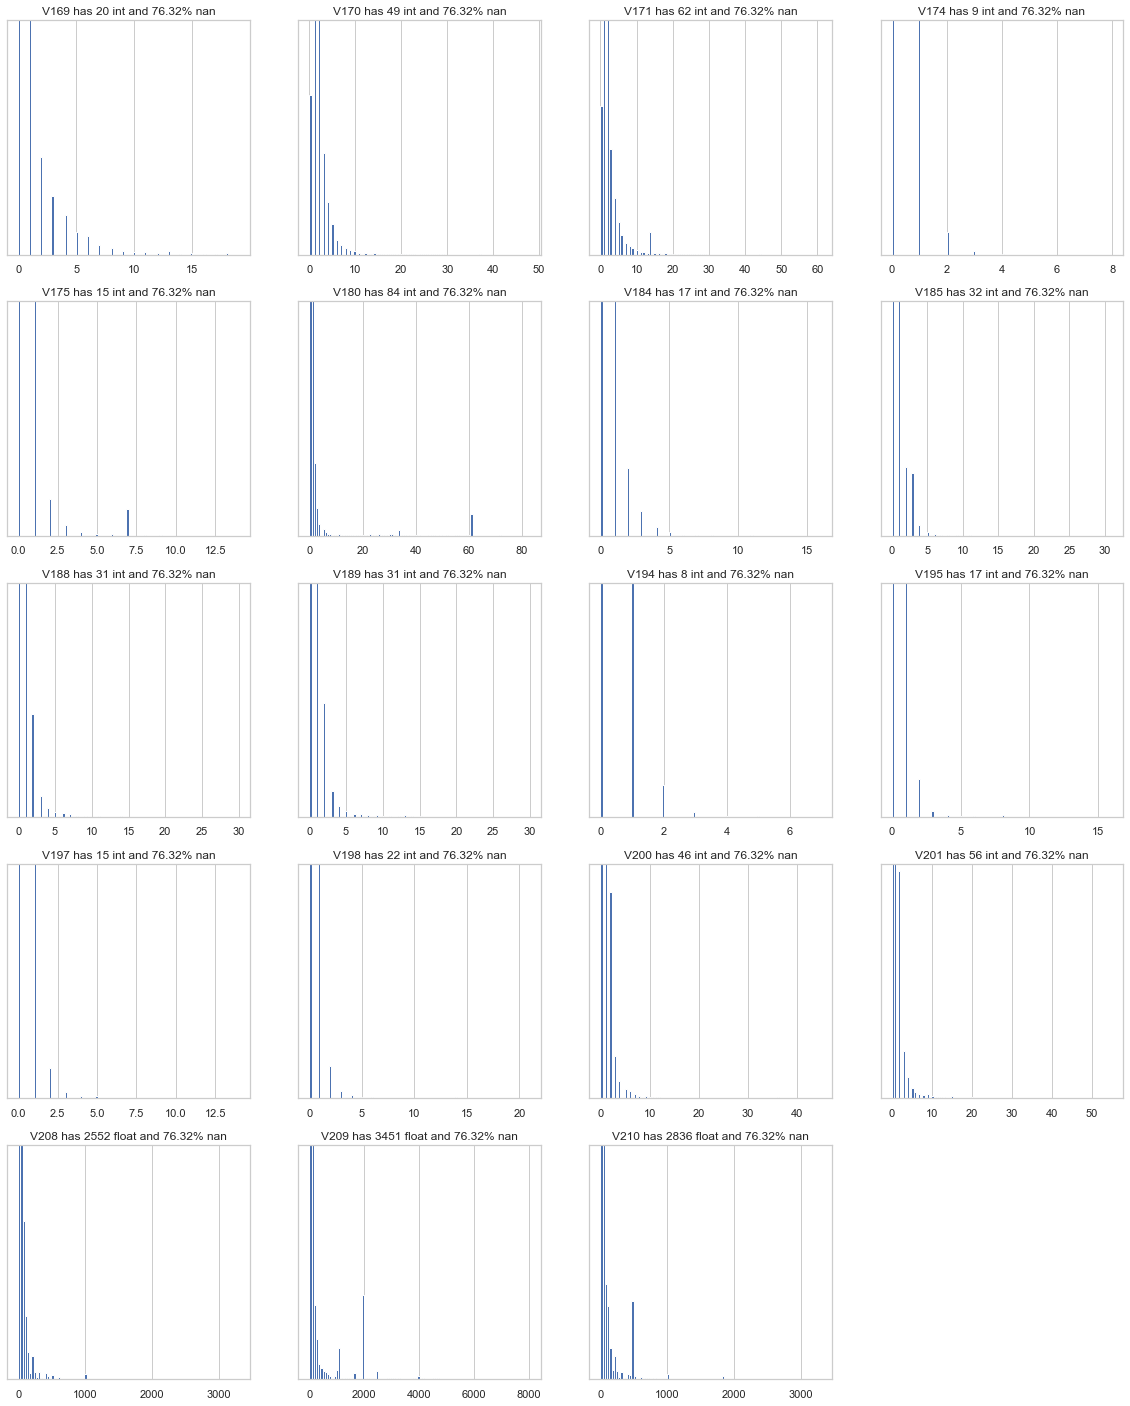

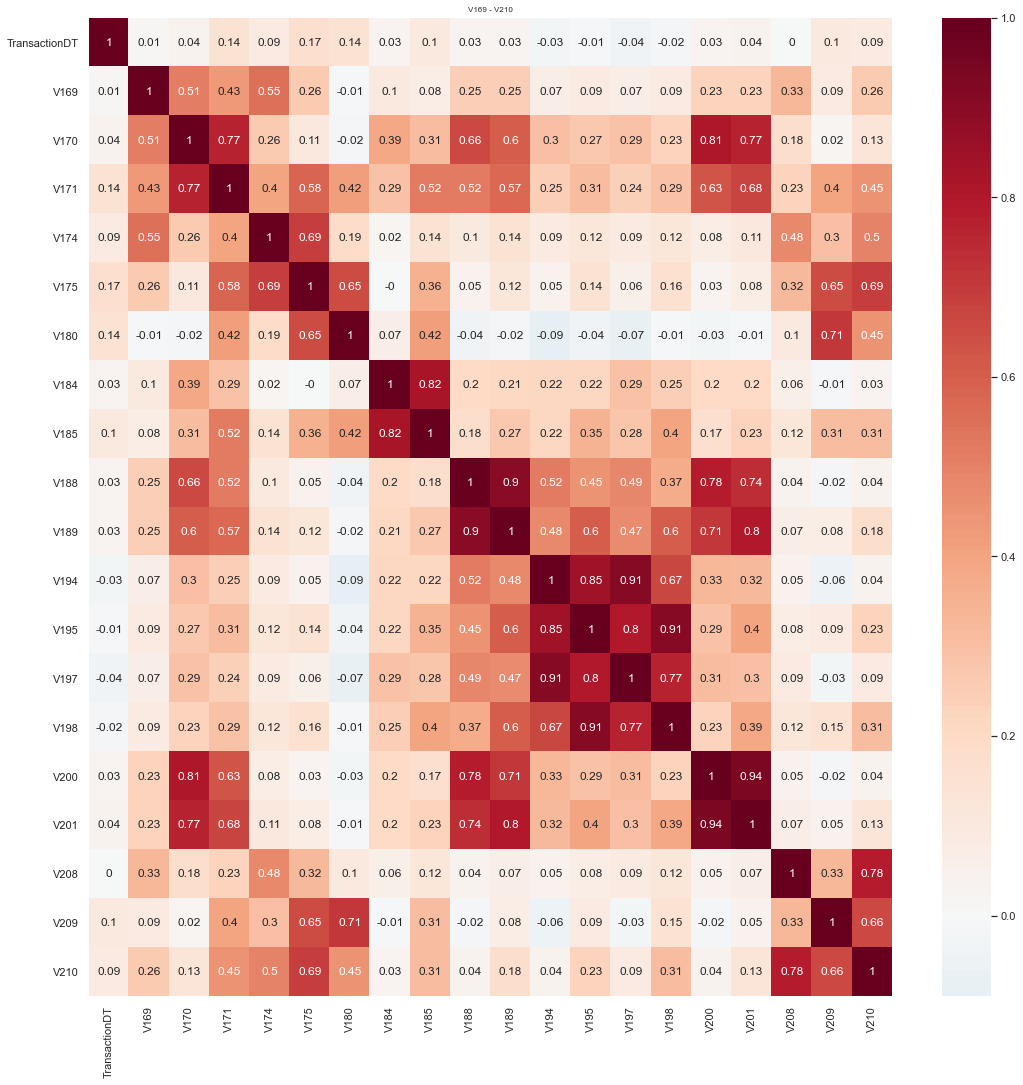

In [63]:
Vs = nans_groups[450721]
make_plots(Vs)
make_corr(Vs)

In [64]:
grps = [[169],[170,171,200,201],[174,175],[180],[184,185],[188,189],[194,195,197,198],[208,210],[209]]
reduce_group(grps)

Use these [169, 171, 175, 180, 185, 188, 198, 210, 209]


### V217 ~ V278

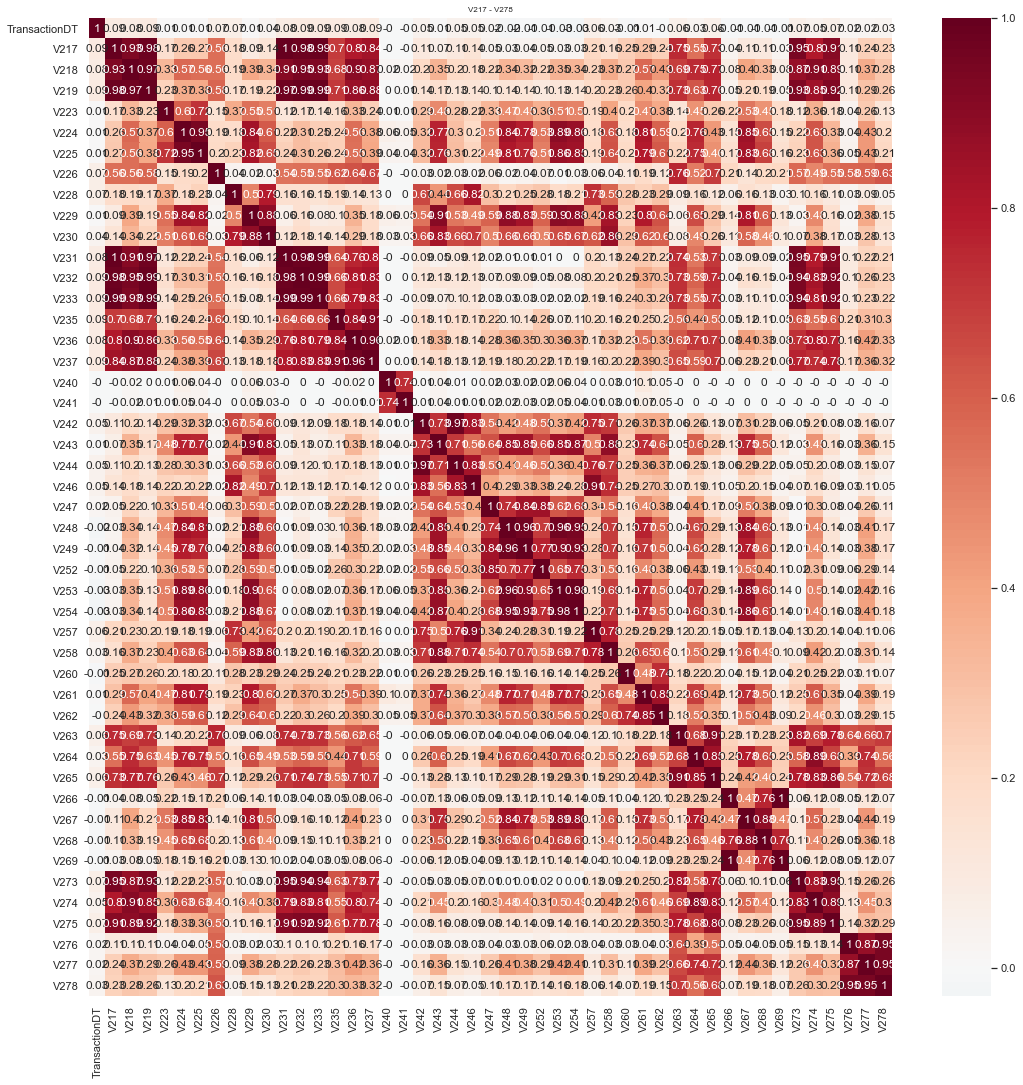

In [65]:
Vs = [x for x in nans_groups[460110]]
make_corr(Vs)

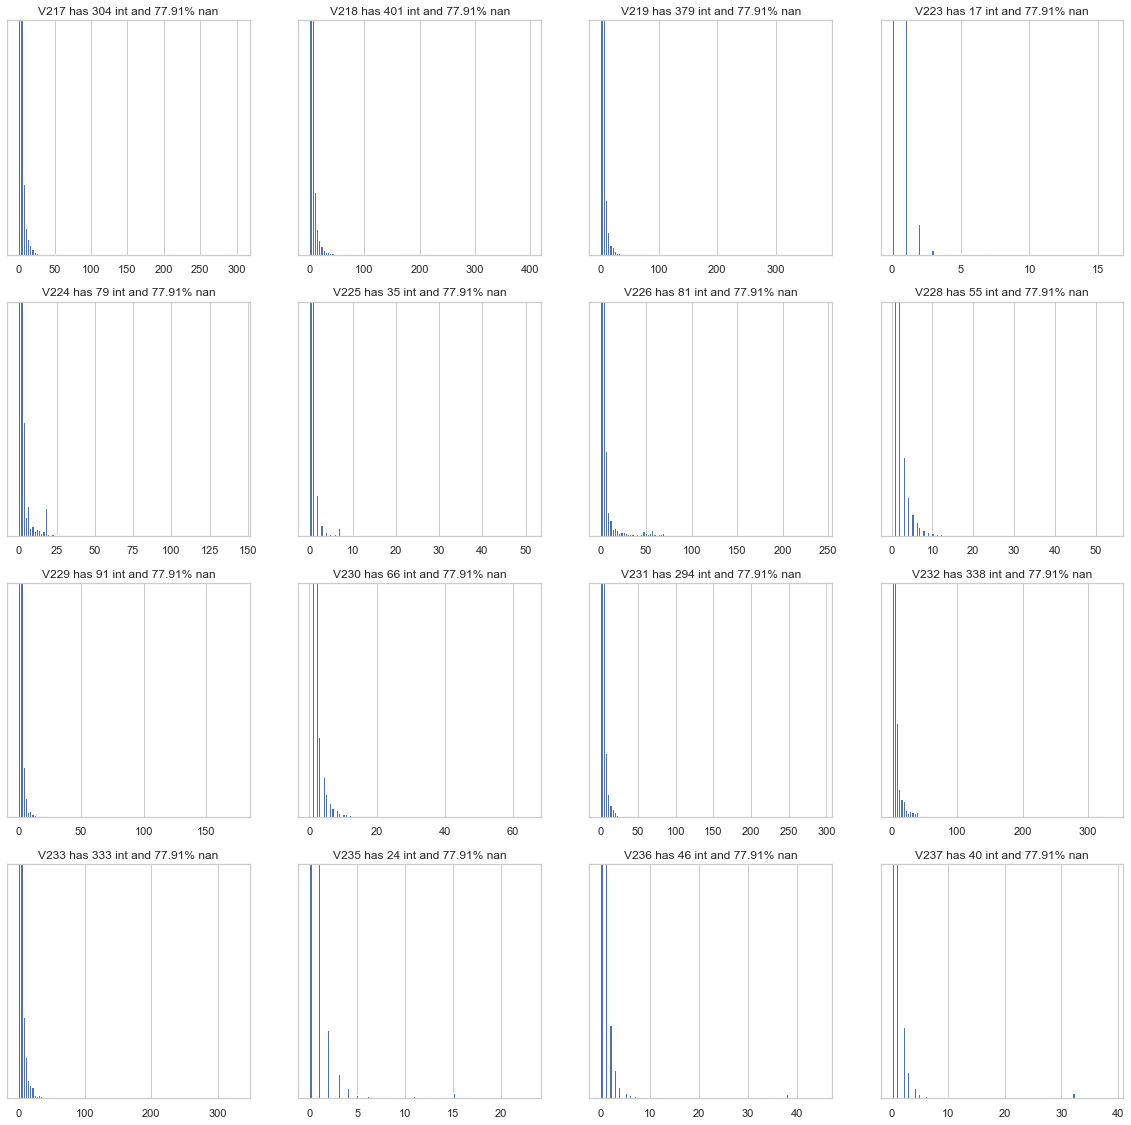

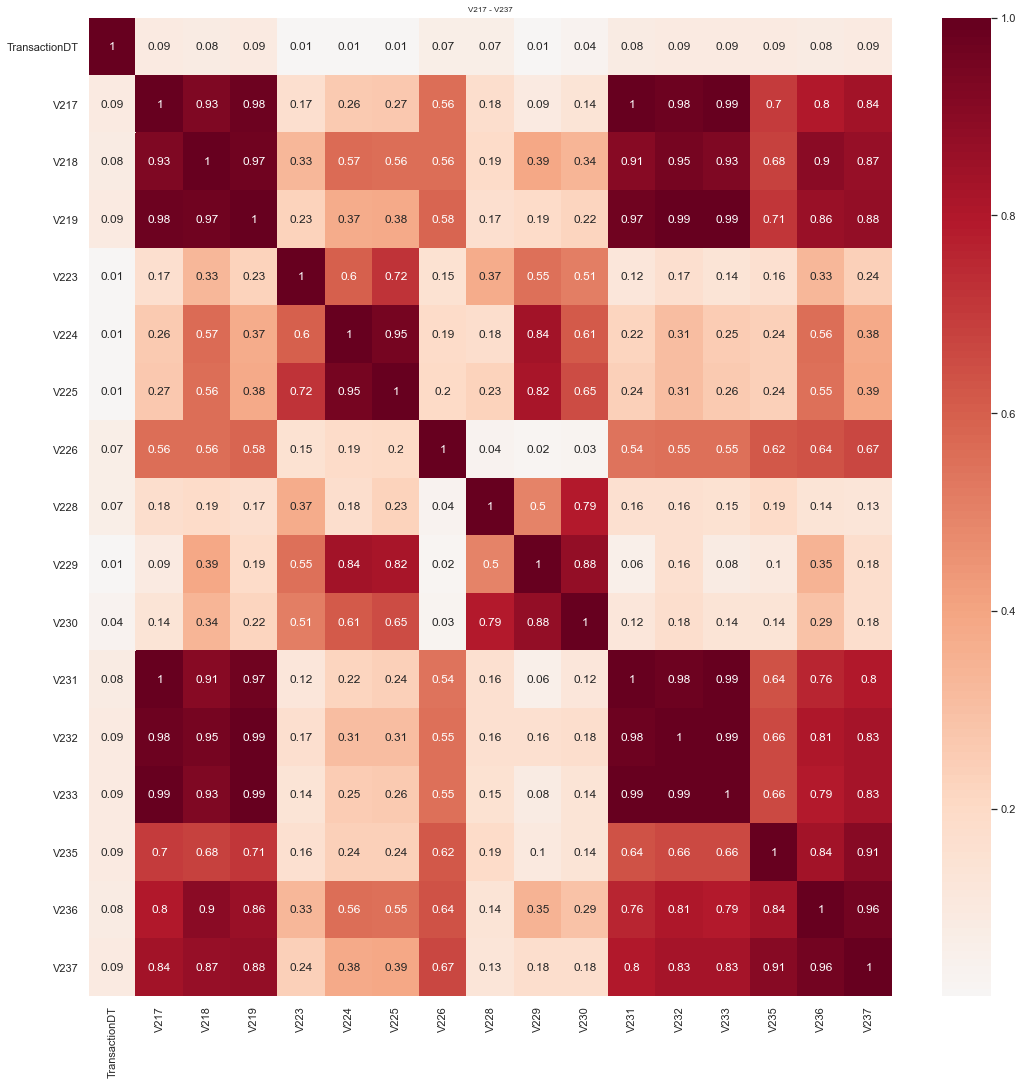

In [66]:
Vs = [x for x in nans_groups[460110] if int(x[1:])<240]
make_plots(Vs)
make_corr(Vs)

In [67]:
grps = [[217,218,219,231,232,233,236,237],[223],[224,225],[226],[228],[229,230],[235]]
reduce_group(grps)

Use these [218, 223, 224, 226, 228, 229, 235]


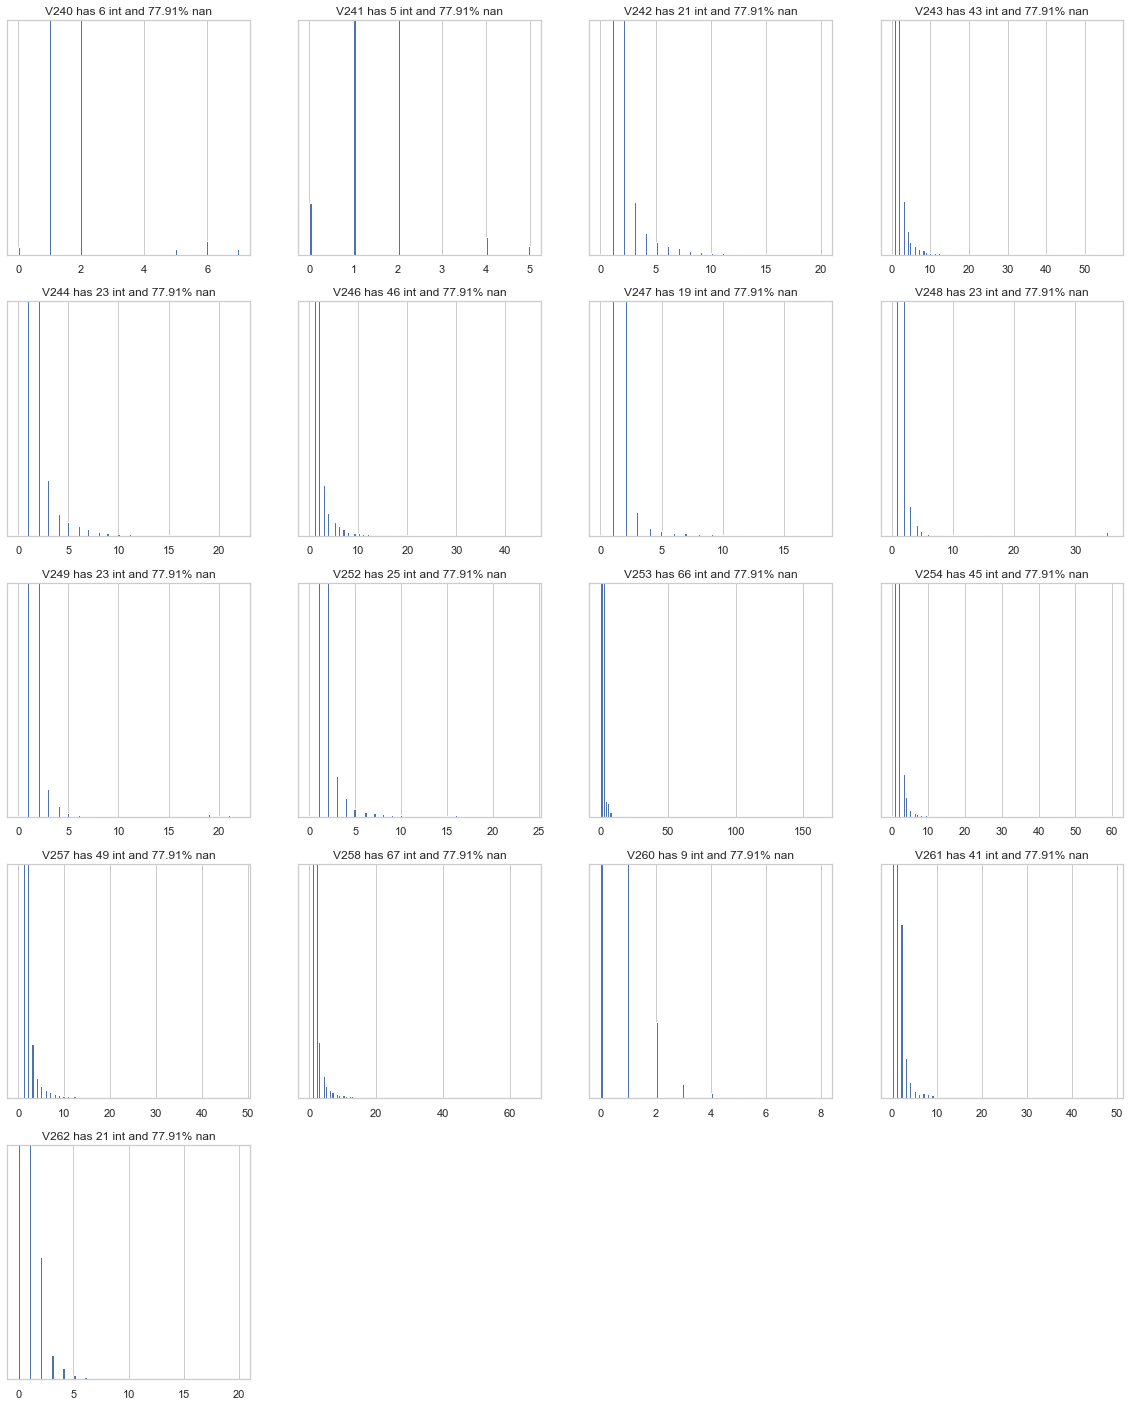

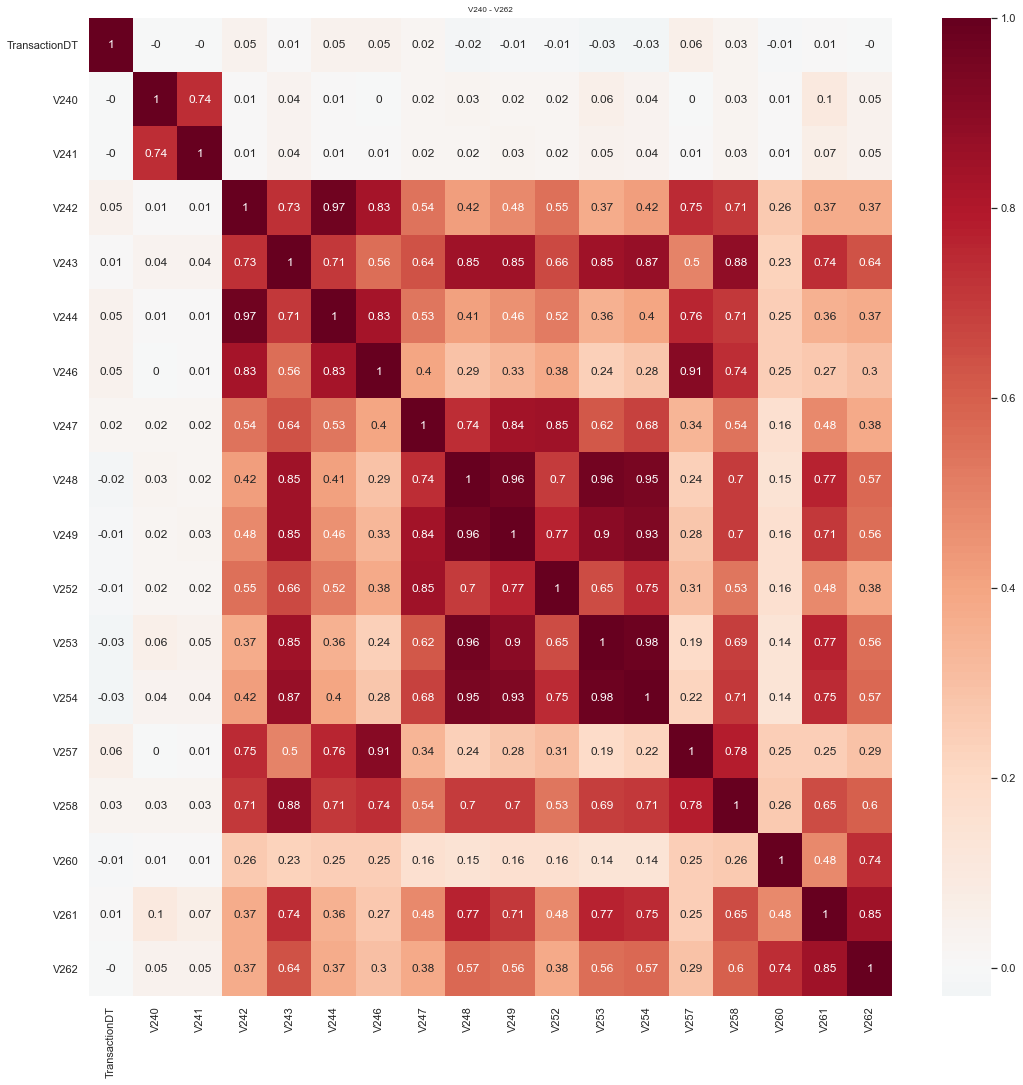

In [68]:
Vs = [x for x in nans_groups[460110] if (int(x[1:])>237)&(int(x[1:])<263)]
make_plots(Vs)
make_corr(Vs)

In [69]:
grps = [[240,241],[242,243,244,258],[246,257],[247,248,249,253,254],[252],[260],[261,262]]
reduce_group(grps)

Use these [240, 258, 257, 253, 252, 260, 261]


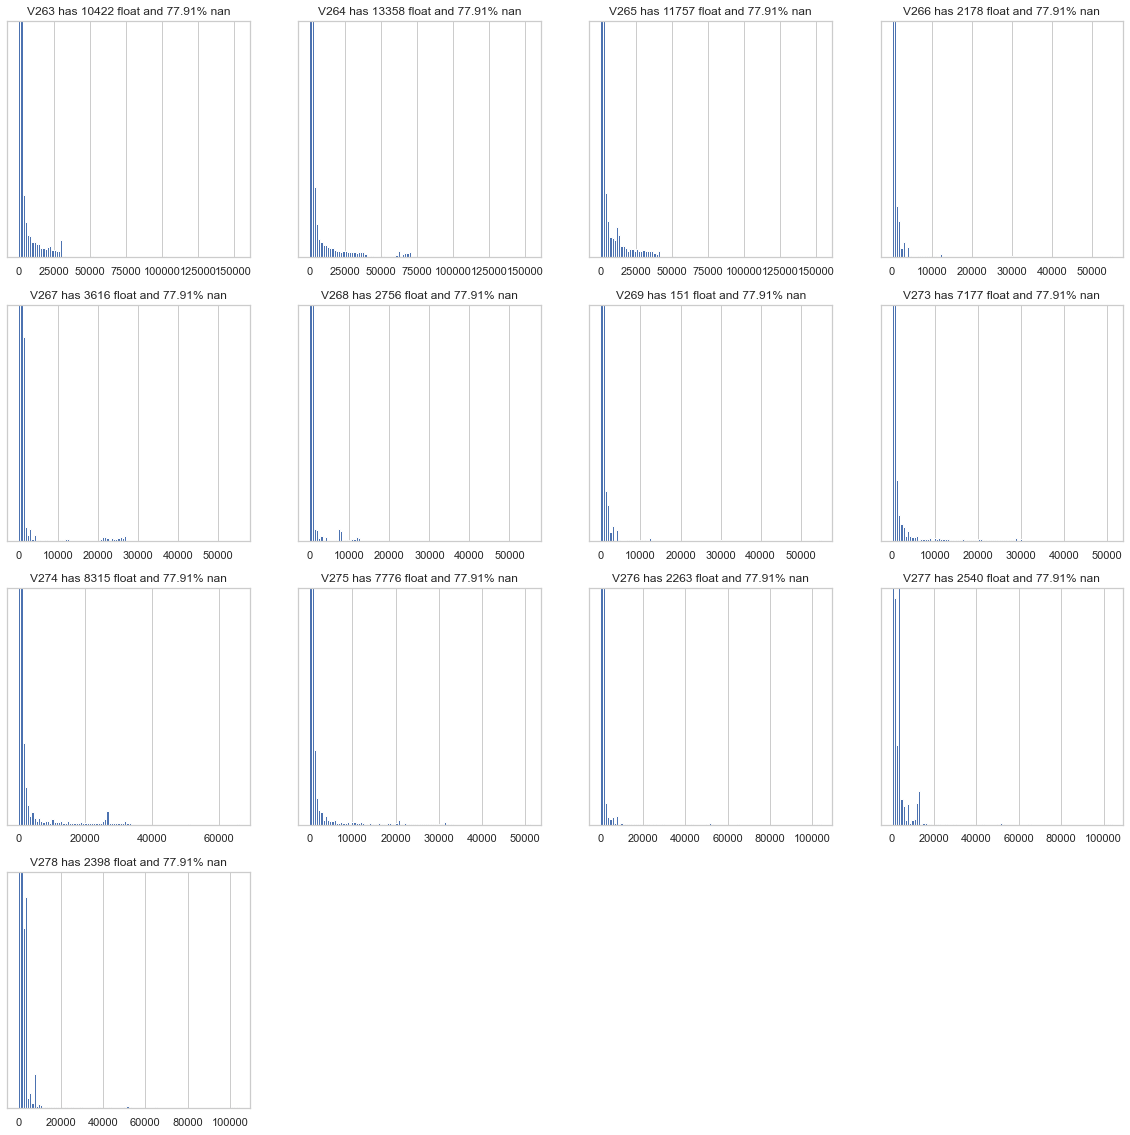

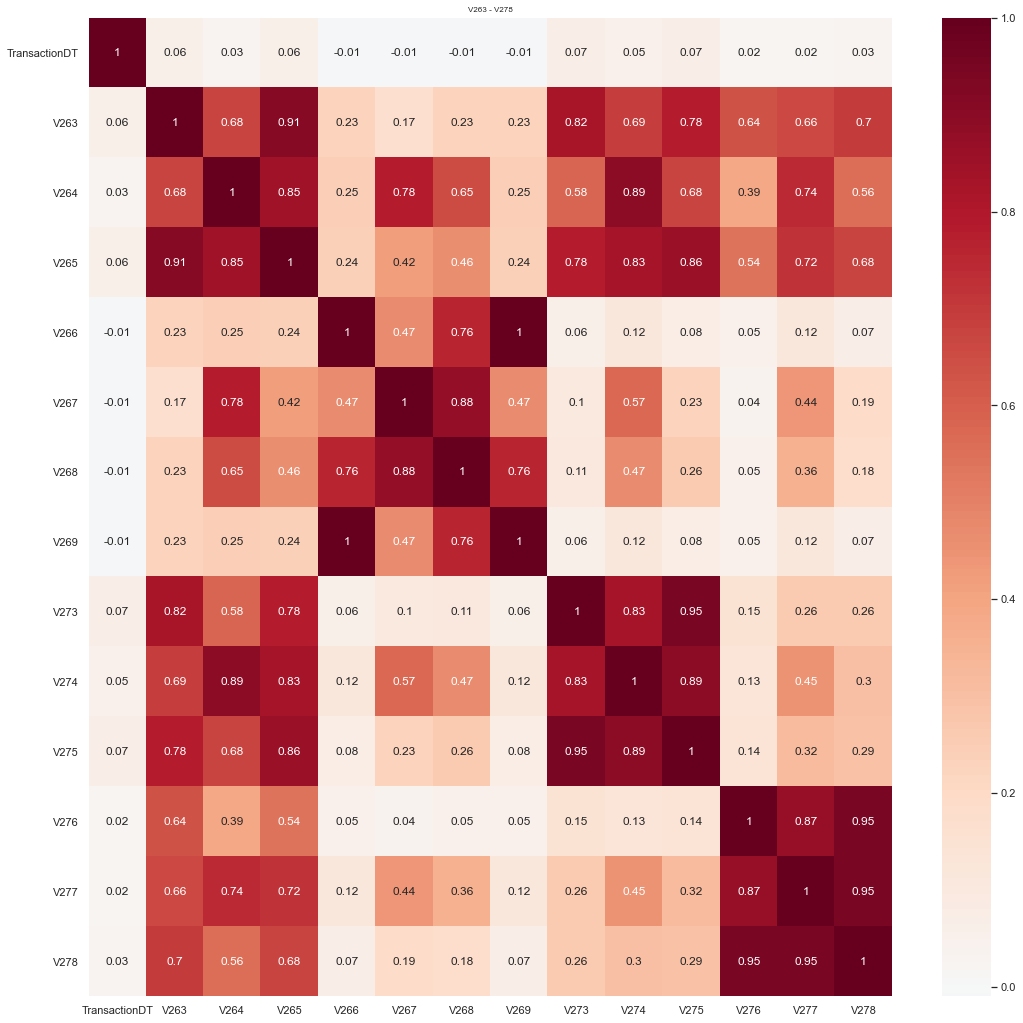

In [70]:
Vs = [x for x in nans_groups[460110] if (int(x[1:])>262)]
make_plots(Vs)
make_corr(Vs)

In [71]:
grps = [[263,265,264],[266,269],[267,268],[273,274,275],[276,277,278]]
reduce_group(grps)

Use these [264, 266, 267, 274, 277]


### V220 ~ V272

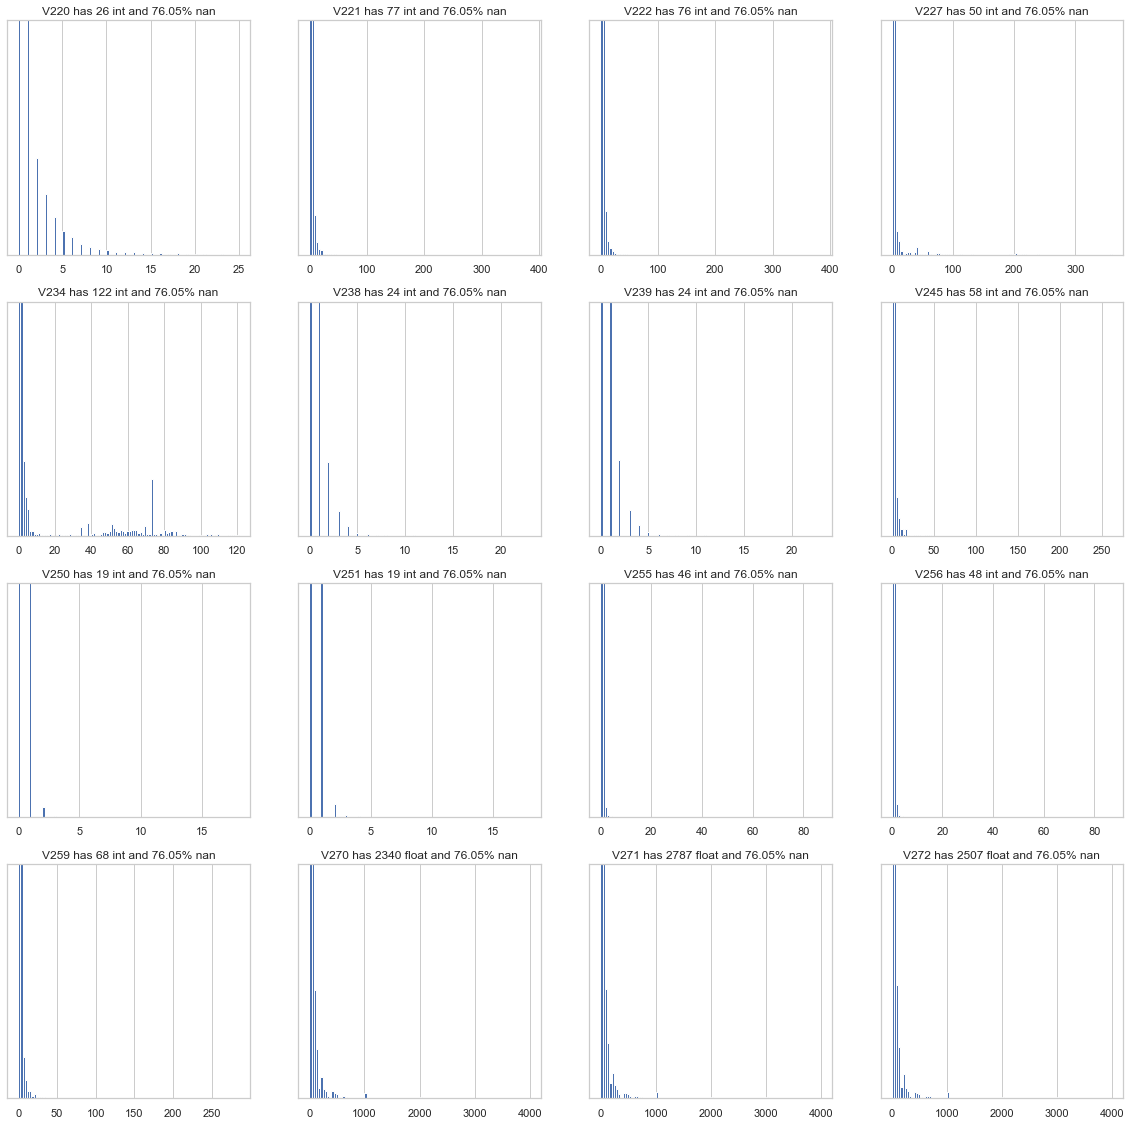

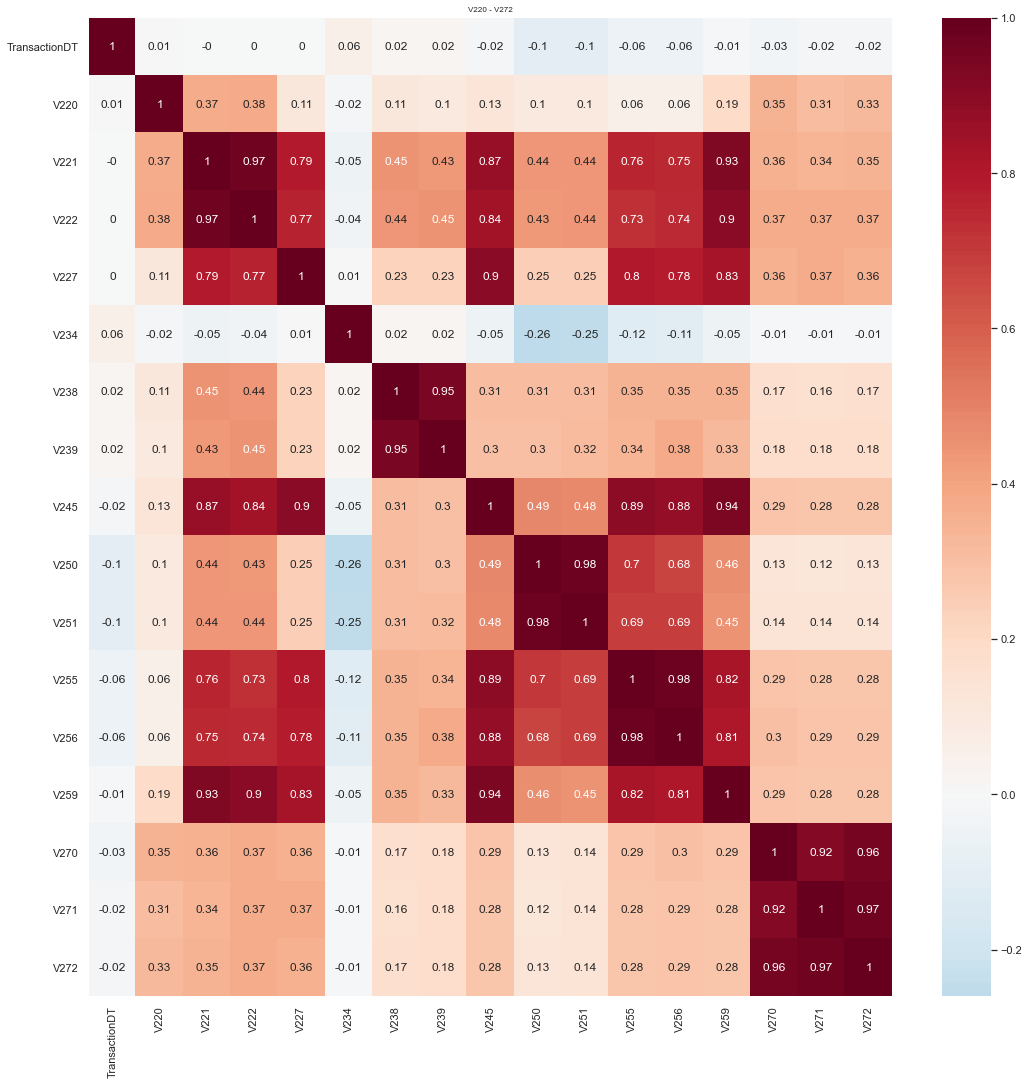

In [72]:
Vs = nans_groups[449124]
make_plots(Vs)
make_corr(Vs)

In [73]:
grps = [[220],[221,222,227,245,255,256,259],[234],[238,239],[250,251],[270,271,272]]
reduce_group(grps)

Use these [220, 221, 234, 238, 250, 271]


### V281 ~ V315, D1

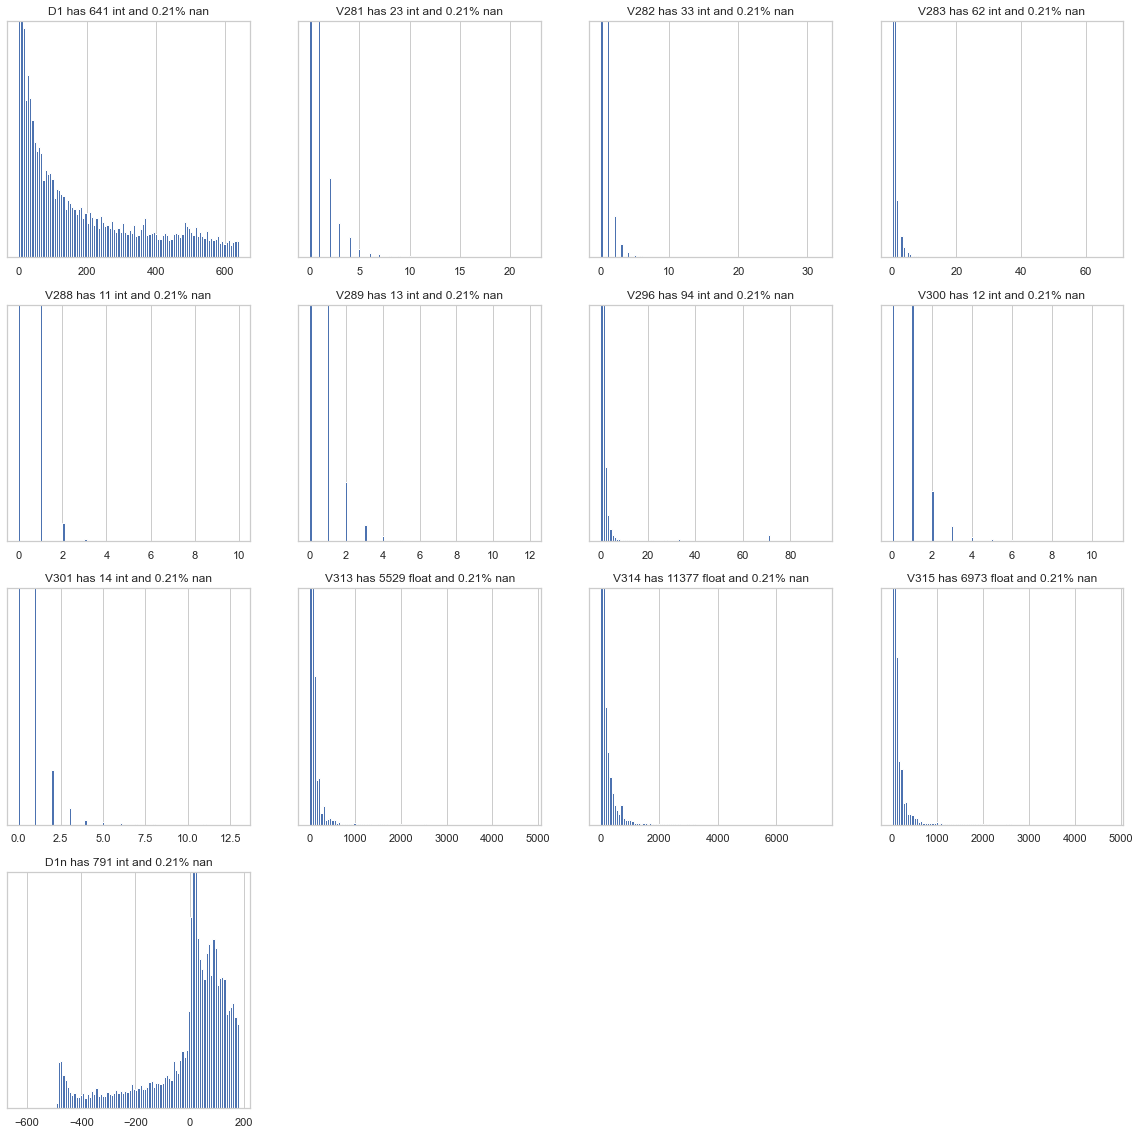

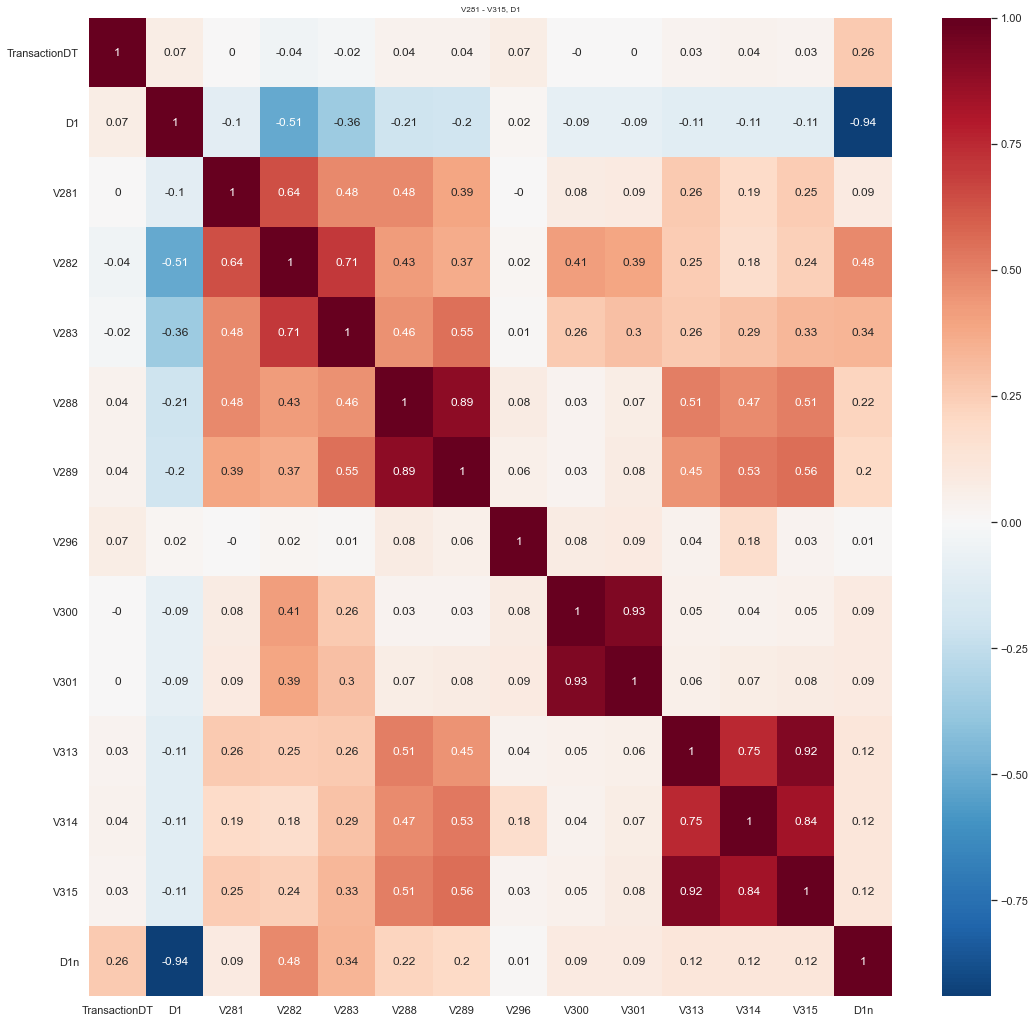

In [74]:
Vs = nans_groups[1269]
make_plots(Vs)
Vtitle = 'V281 - V315, D1'
make_corr(Vs,Vtitle)

In [75]:
grps = [[281],[282,283],[288,289],[296],[300,301],[313,314,315]]
reduce_group(grps)

Use these [281, 283, 289, 296, 301, 314]


### V322 - V339

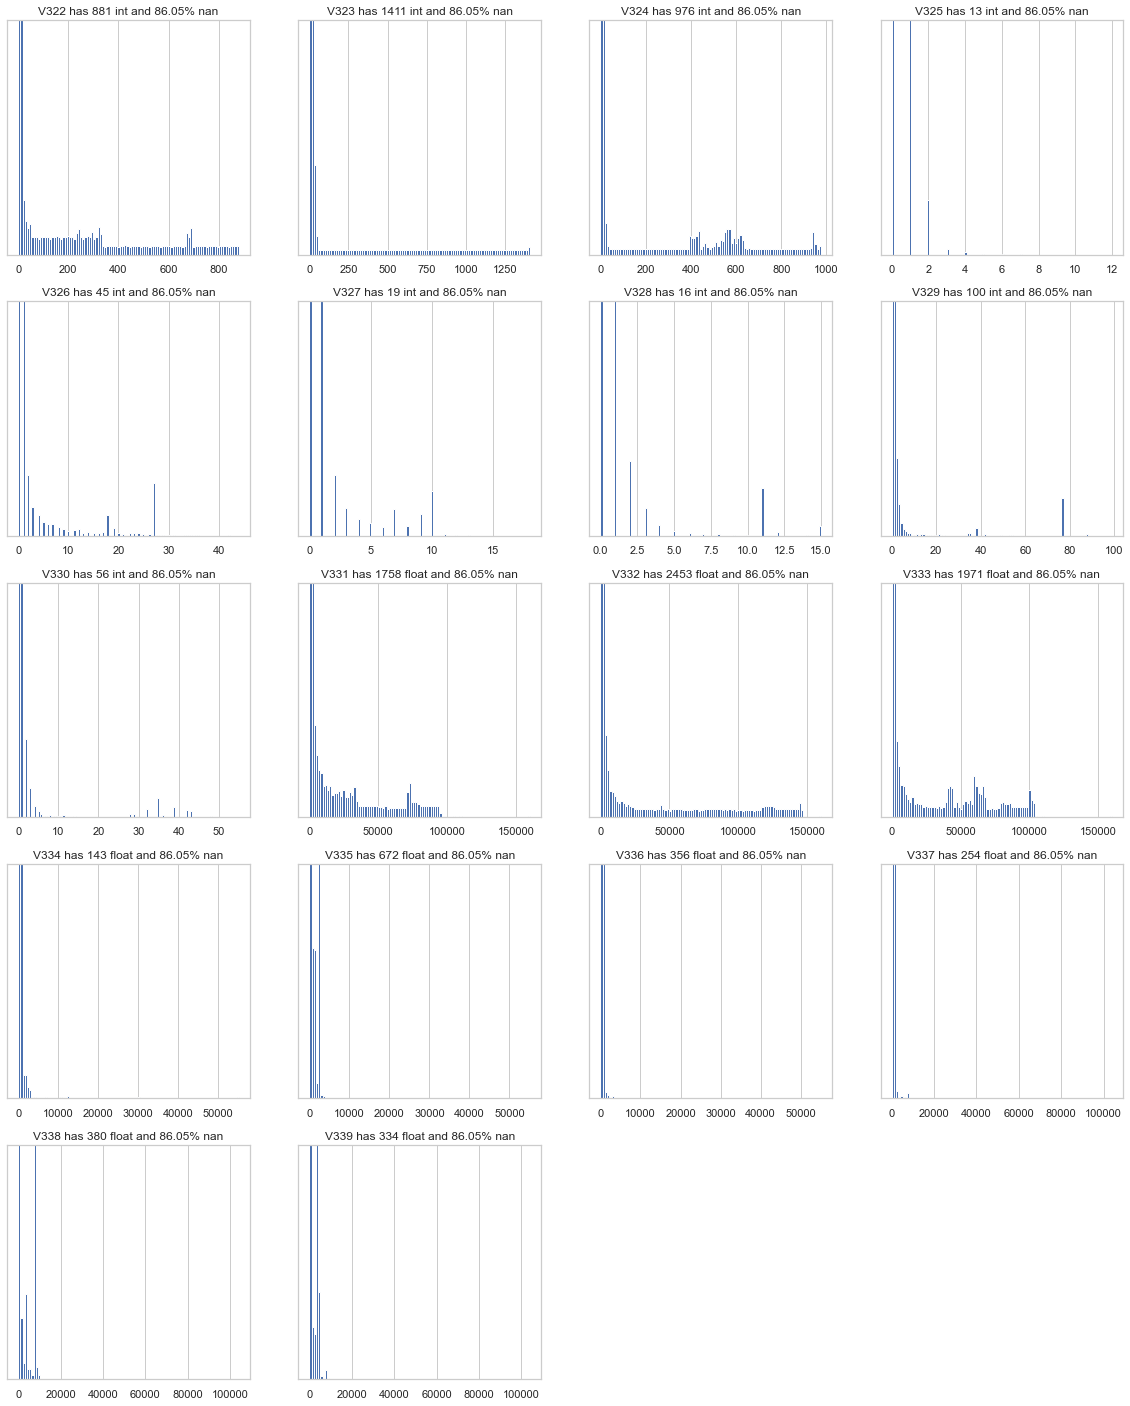

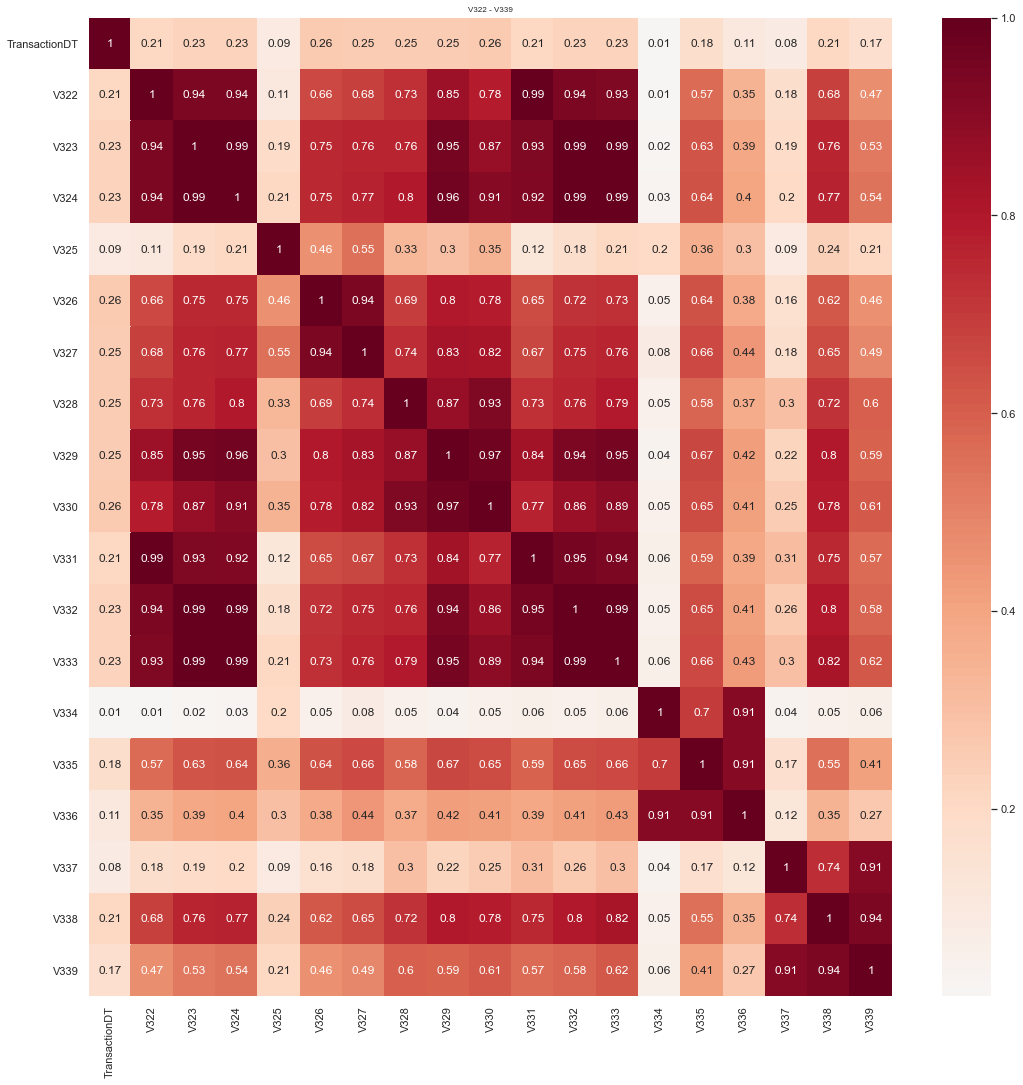

In [76]:
Vs = nans_groups[508189]
make_plots(Vs)
make_corr(Vs)

In [77]:
grps = [[322,323,324,326,327,328,329,330,331,332,333],[325],[334,335,336],[337,338,339]]
reduce_group(grps)

Use these [332, 325, 335, 338]


### V All

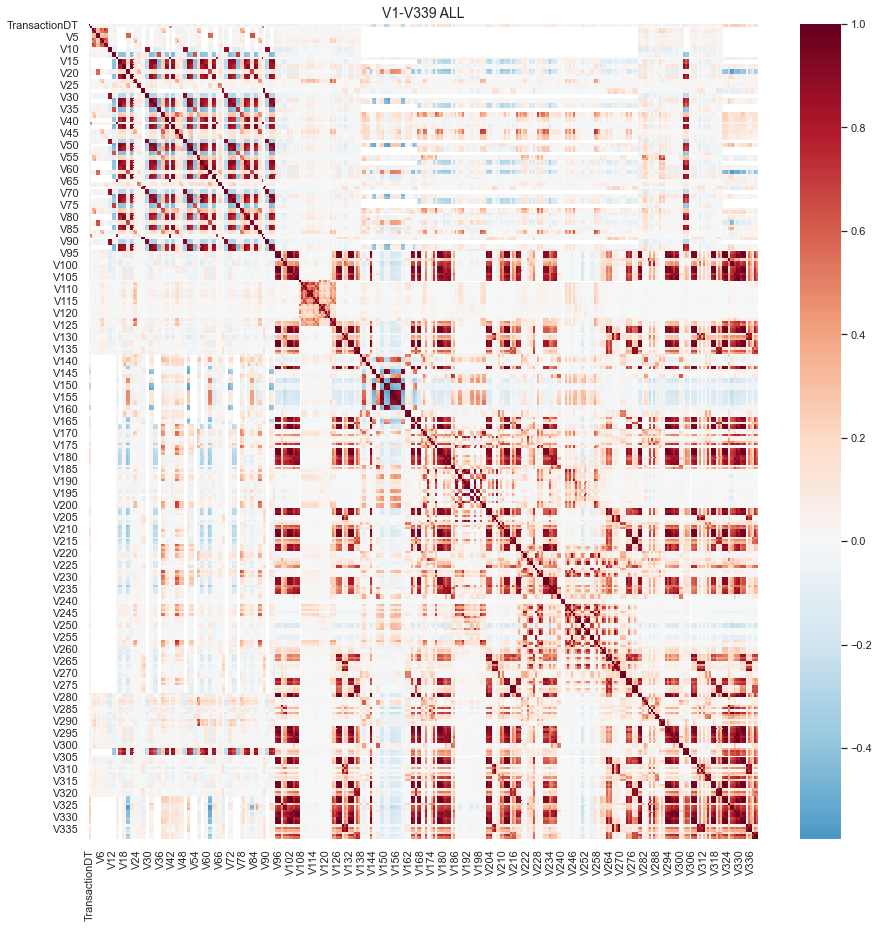

In [78]:
cols = ['TransactionDT'] + ['V'+str(x) for x in range(1,340)]
train2 = train_df[cols].sample(frac=0.2)
plt.figure(figsize=(15,15))
sns.heatmap(train2[cols].corr(), cmap='RdBu_r', annot=False, center=0.0)
plt.title('V1-V339 ALL',fontsize=14)
plt.show()

### V Reduced

In [79]:
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]
v += [96, 98, 99, 104]
v += [107, 108, 111, 115, 117, 120, 121, 123]
v += [124, 127, 129, 130, 136]
v += [138, 139, 142, 147, 156, 162]
v += [165, 160, 166]
v += [178, 176, 173, 182]
v += [187, 203, 205, 207, 215]
v += [169, 171, 175, 180, 185, 188, 198, 210, 209]
v += [218, 223, 224, 226, 228, 229, 235]
v += [240, 258, 257, 253, 252, 260, 261]
v += [264, 266, 267, 274, 277]
v += [220, 221, 234, 238, 250, 271]
v += [294, 284, 285, 286, 291, 297]
v += [303, 305, 307, 309, 310, 320]
v += [281, 283, 289, 296, 301, 314]
v += [332, 325, 335, 338]

In [80]:
print('Reduced set has',len(v),'columns')

Reduced set has 128 columns


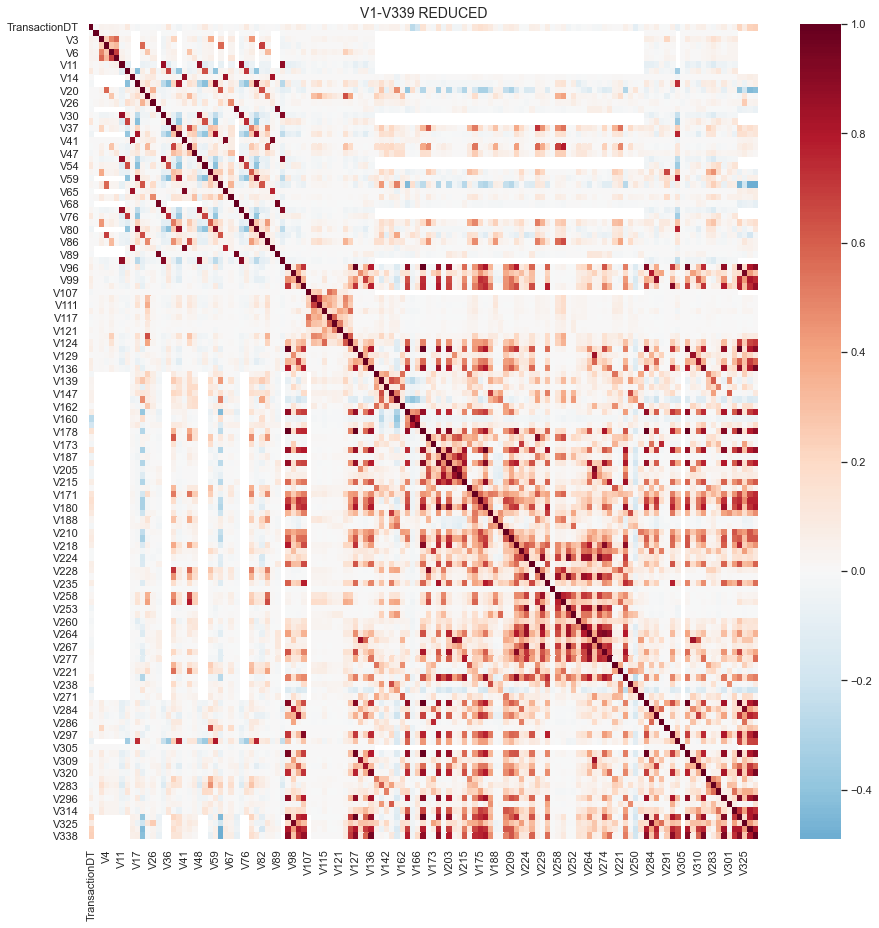

In [81]:
cols = ['TransactionDT'] + ['V'+str(x) for x in v]
train2 = train_df[cols].sample(frac=0.2)
plt.figure(figsize=(15,15))
sns.heatmap(train2[cols].corr(), cmap='RdBu_r', annot=False, center=0.0)
plt.title('V1-V339 REDUCED',fontsize=14)
plt.show()